In [1]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import torch.nn.functional as F

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

from PIL import Image
from sklearn.model_selection import train_test_split
import time
import random
from datetime import datetime
import cv2

# Custom modules and packages
import params.learning
import uncertainty.functions
import uncertainty.evaluation
from utils import compute_mean_std
from dataset import TraversabilityDataset
from model import ResNet18Velocity_Regression_Alt
from train import train
from validate import validate
from test import test, test_models
from result import parameters_table, generate_log
from custom_transforms import Cutout, Shadowcasting

## Load learning parameters

In [2]:
LEARNING_PARAMS = params.learning.LEARNING
NET_PARAMS = params.learning.NET_PARAMS

## Prepare data

#### Compute the mean and the standard deviation of the images set

In [3]:
# Load pre-computed mean and std
NORMALIZE_PARAMS = params.learning.NORMALIZE_PARAMS

normalize_params_recompute = False

if normalize_params_recompute:
    mean, std = compute_mean_std("images_train", "traversal_costs_train.csv")
    NORMALIZE_PARAMS = {"rbg": {"mean": mean[:3],
                                "std": std[:3]},
                        "depth": {"mean": mean[3],
                                  "std": std[3]},
                        "normal": {"mean": mean[4:],
                                   "std": std[4:]}}

print(NORMALIZE_PARAMS)

{'rbg': {'mean': tensor([0.4710, 0.5030, 0.4580]), 'std': tensor([0.1965, 0.1859, 0.1955])}, 'depth': {'mean': tensor([0.0855]), 'std': tensor([0.0684])}, 'normal': {'mean': tensor([0.4981, 0.5832, 0.8387]), 'std': tensor([0.1720, 0.1991, 0.1468])}}


In [4]:
# Compose several transforms together to be applied to training data
# (Note that transforms are not applied yet)
train_transform = transforms.Compose([
    # Reduce the size of the images
    # (if size is an int, the smaller edge of the
    # image will be matched to this number and the ration is kept)
    # transforms.Resize(100),
    transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
    
    # Perform horizontal flip of the image with a probability of 0.5
    # transforms.RandomHorizontalFlip(p=0.5),
    
    # Modify the brightness and the contrast of the image
    transforms.ColorJitter(**params.learning.JITTER_PARAMS),

    # Randomly adds a black patch to the image
    Cutout(0.5),
    
    # Randomly cast a shadow on the image
    Shadowcasting(0.5),

    # Convert a PIL Image or numpy.ndarray to tensor
    transforms.ToTensor(),
    
    # Add some random gaussian noise to the image
    transforms.Lambda(lambda x: x + (0.001**0.5)*torch.randn(x.shape)),
    
    # Normalize a tensor image with pre-computed mean and standard deviation
    # (based on the data used to train the model(s))
    # (be careful, it only works on torch.*Tensor)
    transforms.Normalize(
        mean=NORMALIZE_PARAMS["rbg"]["mean"],
        std=NORMALIZE_PARAMS["rbg"]["std"]
    ),
])

# Define a different set of transforms testing
# (for instance we do not need to flip the image)
test_transform = transforms.Compose([
    # transforms.Resize(100),
    transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
    # transforms.Grayscale(),
    # transforms.CenterCrop(100),
    # transforms.RandomCrop(100),
    transforms.ToTensor(),
    
    # Mean and standard deviation were pre-computed on the training data
    # (on the ImageNet dataset)
    transforms.Normalize(
        mean=NORMALIZE_PARAMS["rbg"]["mean"],
        std=NORMALIZE_PARAMS["rbg"]["std"]
    ),
])

transform_depth = transforms.Compose([
        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
        
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
        
        # Normalize a tensor image with pre-computed mean and standard deviation
        # (based on the data used to train the model(s))
        # (be careful, it only works on torch.*Tensor)
        transforms.Normalize(
            mean=NORMALIZE_PARAMS["depth"]["mean"],
            std=NORMALIZE_PARAMS["depth"]["std"]
        ),
])

transform_normal = transforms.Compose([
        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
        
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
        
        # Normalize a tensor image with pre-computed mean and standard deviation
        # (based on the data used to train the model(s))
        # (be careful, it only works on torch.*Tensor)
        transforms.Normalize(
            mean=NORMALIZE_PARAMS["normal"]["mean"],
            std=NORMALIZE_PARAMS["normal"]["std"]
        ),
])


# Create a Dataset for training
train_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET+"traversal_costs_train.csv",
    images_directory=params.learning.DATASET+"images_train",
    transform_image=train_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal
)

# Create a Dataset for validation
val_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET+"traversal_costs_train.csv",
    images_directory=params.learning.DATASET+"images_train",
    transform_image=test_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal
)

# Create a Dataset for testin
test_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET+"traversal_costs_test.csv",
    images_directory=params.learning.DATASET+"images_test",
    transform_image=test_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal
)

# Set the train dataset size
train_size = params.learning.TRAIN_SIZE/(1-params.learning.TEST_SIZE)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)),
                                              train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [5]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [6]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

70.0 % of the data for training (181 samples)
15.0 % of the data for validation (39 samples)
15.0 % of the data for testing (39 samples)


## GPU?

In [7]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Training and validation

In [8]:
# Create a model

model = ResNet18Velocity_Regression_Alt(nb_input_channels=NET_PARAMS["nb_input_channels"],
                                    nb_input_features=NET_PARAMS["nb_input_features"],
                                    nb_classes=1).to(device=device)

In [9]:
# Create dummy tensors
images = torch.randn(32,
                     params.learning.NET_PARAMS["nb_input_channels"],
                     params.learning.IMAGE_SHAPE[0],
                     params.learning.IMAGE_SHAPE[1]).to(device=device)  # (batch, channels, height, width)
data = torch.randn(32, 1).to(device=device)  # (batch, features)

print(model(images, data).shape)

torch.Size([32])


#### Visualize the model

In [10]:
# Open TensorBoard
# tensorboard = SummaryWriter()

# Display the architecture in TensorBoard
# images, traversal_costs, traversability_labels, linear_velocities = next(iter(train_loader))
# images = images.to(device)
# linear_velocities = linear_velocities.type(torch.float32).to(device)

# Add a dimension to the linear velocities tensor
# linear_velocities.unsqueeze_(1)

# tensorboard.add_graph(model, (images, linear_velocities))

print(model)
# print(torchsummary.summary(model, (3, 100, 100)))
# print([(name, param.shape) for name, param in model.named_parameters()])
# print(model.fc.state_dict())

ResNet18Velocity_Regression_Alt(
  (resnet18): ResNet(
    (conv1): Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.

In [11]:
# Loss function to compare the expected traversal cost over the bins
# and the ground truth traversal cost
criterion_regression = nn.MSELoss()

# Get all the parameters excepts the weights and bias of fc layer
base_params = [param for name, param in model.named_parameters()
               if name not in ["resnet18.fc.weight", "resnet18.fc.bias"]]

# Define the optimizer, with a greater learning rate for the new fc layer
# optimizer = optim.SGD([
#     {"params": base_params},
#     {"params": model.resnet18.fc.parameters(),
#      "lr": LEARNING_PARAMS["learning_rate"]*10},
# ],
#     lr=LEARNING_PARAMS["learning_rate"],
#     momentum=LEARNING_PARAMS["momentum"],
#     weight_decay=LEARNING_PARAMS["weight_decay"])

optimizer = optim.SGD(model.parameters(),
                      lr=LEARNING_PARAMS["learning_rate"],
                      momentum=LEARNING_PARAMS["momentum"],
                      weight_decay=LEARNING_PARAMS["weight_decay"])

scheduler = optim.lr_scheduler.LinearLR(optimizer=optimizer, total_iters=LEARNING_PARAMS["nb_epochs"])

# Create tensors to store the loss and accuracy values
regression_loss_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Loop over the epochs
for epoch in range(LEARNING_PARAMS["nb_epochs"]):
    
    # Training
    train_regression_loss = train(model,
                                  device,
                                  train_loader,
                                  optimizer,
                                  scheduler,
                                  criterion_regression,
                                  epoch)
    
    # Validation
    val_regression_loss = validate(model,
                                   device,
                                   val_loader,
                                   criterion_regression,
                                   epoch) 
    
    print("Train regression loss: ", train_regression_loss)
    print("Validation regression loss: ", val_regression_loss)

    # Store the computed regression losses
    regression_loss_values[0, epoch] = train_regression_loss
    regression_loss_values[1, epoch] = val_regression_loss
    
#     # Add the losses to TensorBoard
#     tensorboard.add_scalar("train_loss", train_loss, epoch)
#     tensorboard.add_scalar("val_loss", val_loss, epoch)
#     # Add the accuracies to TensorBoard
#     tensorboard.add_scalar("train_accuracy", train_accuracy, epoch)
#     tensorboard.add_scalar("val_accuracy", val_accuracy, epoch)
#     # Add the regression losses to TensorBoard
#     tensorboard.add_scalar("train_regression_loss", train_regression_loss, epoch)
#     tensorboard.add_scalar("val_regression_loss", val_regression_loss, epoch)

# # Close TensorBoard
# tensorboard.close()

  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  3.0082224210103354
Validation regression loss:  3.264788866043091


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  2.7715513706207275
Validation regression loss:  3.3894357681274414


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  2.3245713909467063
Validation regression loss:  2.692638874053955


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  1.9130277434984844
Validation regression loss:  2.4727131128311157


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  1.581918438275655
Validation regression loss:  2.550510883331299


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  1.2902469635009766
Validation regression loss:  1.8141698241233826


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  1.054300844669342
Validation regression loss:  1.6414183378219604


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.8535652011632919
Validation regression loss:  1.5663267970085144


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.7341345051924387
Validation regression loss:  0.9172510057687759


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.6174841076135635
Validation regression loss:  0.9950487315654755


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.5933675616979599
Validation regression loss:  1.411556988954544


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.5015368858973185
Validation regression loss:  0.7973176836967468


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.4560346305370331
Validation regression loss:  0.9617685973644257


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.4255336175362269
Validation regression loss:  1.091699242591858


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.3939886863032977
Validation regression loss:  0.6504644006490707


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.41726432740688324
Validation regression loss:  0.8062848150730133


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.39462349315484363
Validation regression loss:  0.6489559412002563


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.41346869866053265
Validation regression loss:  0.8569169640541077


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.38040579855442047
Validation regression loss:  0.9443986117839813


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.35149909059206647
Validation regression loss:  0.706894189119339


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.3561140050490697
Validation regression loss:  0.8689695298671722


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.3876222123702367
Validation regression loss:  0.5945283621549606


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.40016130606333417
Validation regression loss:  0.6021549701690674


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.36527154843012494
Validation regression loss:  0.5290471166372299


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.33303703367710114
Validation regression loss:  0.5624215304851532


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.3829670548439026
Validation regression loss:  0.6449437737464905


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.3615544040997823
Validation regression loss:  0.6160080432891846


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.3355616480112076
Validation regression loss:  0.9377209544181824


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.3409431576728821
Validation regression loss:  0.5839925408363342


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.3338976750771205
Validation regression loss:  0.7597996890544891


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.3158787464102109
Validation regression loss:  0.7189691960811615


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.32871803144613904
Validation regression loss:  0.8570183217525482


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.33436058461666107
Validation regression loss:  0.7051095366477966


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.3164565737048785
Validation regression loss:  0.6263910233974457


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.3192301740248998
Validation regression loss:  0.6147817075252533


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.3327082345883052
Validation regression loss:  0.7042895257472992


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.3166353752215703
Validation regression loss:  0.6074475049972534


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.33080215752124786
Validation regression loss:  0.6418698132038116


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.31388922532399494
Validation regression loss:  0.4318552389740944


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.31609325607617694
Validation regression loss:  0.7574610412120819


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.31167101363341015
Validation regression loss:  0.5284482687711716


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.3091367656985919
Validation regression loss:  0.47346803545951843


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.30814405779043835
Validation regression loss:  0.5814329981803894


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.29650503148635227
Validation regression loss:  0.8148815780878067


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2914641946554184
Validation regression loss:  0.6297444403171539


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.3129843647281329
Validation regression loss:  0.4831838756799698


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.3186205377181371
Validation regression loss:  0.6737001240253448


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.3123256216446559
Validation regression loss:  0.5227331221103668


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.3090958818793297
Validation regression loss:  0.6857761740684509


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.321278194586436
Validation regression loss:  0.5253318548202515


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2880484014749527
Validation regression loss:  0.45663437247276306


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.3067672501007716
Validation regression loss:  0.4958760589361191


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.3009080837170283
Validation regression loss:  0.4515168219804764


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.299320047100385
Validation regression loss:  0.5675572156906128


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2908681432406108
Validation regression loss:  0.5871312916278839


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2963862046599388
Validation regression loss:  0.5203610360622406


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2872834453980128
Validation regression loss:  0.4324302524328232


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.29683513442675274
Validation regression loss:  0.47721657156944275


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.3166923175255458
Validation regression loss:  0.7247131168842316


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.280823677778244
Validation regression loss:  0.4128858521580696


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.27449262887239456
Validation regression loss:  0.41755710542201996


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.295285165309906
Validation regression loss:  0.5169139951467514


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.28976230323314667
Validation regression loss:  0.4186668172478676


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2775990863641103
Validation regression loss:  0.540511429309845


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2809179996450742
Validation regression loss:  0.6622886806726456


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2861941456794739
Validation regression loss:  0.45468394458293915


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2788732449213664
Validation regression loss:  0.4403863698244095


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2695445145169894
Validation regression loss:  0.5762683302164078


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.27243736137946445
Validation regression loss:  0.694436326622963


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2809361865123113
Validation regression loss:  0.5325442850589752


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2849585488438606
Validation regression loss:  0.6052093803882599


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2831973508000374
Validation regression loss:  0.6838107258081436


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2744131237268448
Validation regression loss:  0.4961569905281067


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.26328545312086743
Validation regression loss:  0.533438965678215


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2575994407137235
Validation regression loss:  0.6406706869602203


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2778523539503415
Validation regression loss:  0.419735923409462


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.26876497517029446
Validation regression loss:  0.6877515465021133


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2748968427379926
Validation regression loss:  0.48861443996429443


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2609524776538213
Validation regression loss:  0.4872477054595947


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.26745517800251645
Validation regression loss:  0.5007372200489044


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.26237815866867703
Validation regression loss:  0.6038109660148621


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.25624963641166687
Validation regression loss:  0.6309645622968674


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.25978415459394455
Validation regression loss:  0.3883760944008827


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2576543986797333
Validation regression loss:  0.4147365540266037


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.25269700090090436
Validation regression loss:  0.4108453094959259


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2499318098028501
Validation regression loss:  0.4324953854084015


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2632215892275174
Validation regression loss:  0.5629848837852478


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.26260525236527127
Validation regression loss:  0.5548595041036606


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2506134857734044
Validation regression loss:  0.4083026796579361


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2652571275830269
Validation regression loss:  0.47184546291828156


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.25146350264549255
Validation regression loss:  0.6103294342756271


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2470012033979098
Validation regression loss:  0.34803546965122223


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.24935726821422577
Validation regression loss:  0.40807193517684937


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.26910467197497684
Validation regression loss:  0.5719253718852997


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.24682190269231796
Validation regression loss:  0.5987192094326019


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2538415640592575
Validation regression loss:  0.39983195066452026


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.239369735121727
Validation regression loss:  0.3945191502571106


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.24272323151429495
Validation regression loss:  0.4279206246137619


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.24485753228267035
Validation regression loss:  0.40086327493190765


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.24959501127401987
Validation regression loss:  0.5327174514532089


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.24199194461107254
Validation regression loss:  0.3741421326994896


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.24928799519936243
Validation regression loss:  0.5842767357826233


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2548402672012647
Validation regression loss:  0.3358893245458603


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2519256000717481
Validation regression loss:  0.4504949748516083


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2400074079632759
Validation regression loss:  0.45245037972927094


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2316860482096672
Validation regression loss:  0.5242727994918823


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2315082053343455
Validation regression loss:  0.5474965274333954


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.24449522793293
Validation regression loss:  0.3758806139230728


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.24573585639397302
Validation regression loss:  0.3865947276353836


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.23599519828955332
Validation regression loss:  0.36984582245349884


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.23866201688845953
Validation regression loss:  0.48416948318481445


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.23114063590765
Validation regression loss:  0.394519180059433


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.23529261102279028
Validation regression loss:  0.533050462603569


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.24201796452204385
Validation regression loss:  0.3875458538532257


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.23793237408002219
Validation regression loss:  0.7405989170074463


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.22864482055107752
Validation regression loss:  0.3891591727733612


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.22529385735591254
Validation regression loss:  0.6011933833360672


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.23016787817080817
Validation regression loss:  0.42027874290943146


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.23506086319684982
Validation regression loss:  0.40110595524311066


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2317699988683065
Validation regression loss:  0.39040620625019073


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2328880031903585
Validation regression loss:  0.5455056428909302


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.22689726452032724
Validation regression loss:  0.45115701854228973


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.23079515000184378
Validation regression loss:  0.3863608092069626


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2224627286195755
Validation regression loss:  0.4238699972629547


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2289495492974917
Validation regression loss:  0.5833050757646561


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.23401372383038202
Validation regression loss:  0.35970497876405716


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2258093679944674
Validation regression loss:  0.5755586624145508


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.21741080780824026
Validation regression loss:  0.6306432485580444


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2225883478919665
Validation regression loss:  0.5209283828735352


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2242187907298406
Validation regression loss:  0.5219717919826508


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.23390023907025656
Validation regression loss:  0.5087264180183411


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.22966150691111883
Validation regression loss:  0.37736448645591736


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.22132915755112967
Validation regression loss:  0.32568204402923584


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.21874411404132843
Validation regression loss:  0.5649769306182861


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.22369684527317682
Validation regression loss:  0.38718627393245697


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2244035005569458
Validation regression loss:  0.3898710310459137


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.20604075491428375
Validation regression loss:  0.36520417034626007


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.21756470451752344
Validation regression loss:  0.5669645965099335


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.22665559500455856
Validation regression loss:  0.3411324471235275


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.22588197638591131
Validation regression loss:  0.3469444215297699


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.21187439064184824
Validation regression loss:  0.46283158659935


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2192045971751213
Validation regression loss:  0.39663271605968475


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.21823396782080332
Validation regression loss:  0.41144874691963196


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.21852494527896246
Validation regression loss:  0.4893491864204407


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.21439704050620398
Validation regression loss:  0.2960882857441902


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1997071454922358
Validation regression loss:  0.4354947507381439


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.20722371091445288
Validation regression loss:  0.4134790897369385


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2136166642109553
Validation regression loss:  0.3946663439273834


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.20109753559033075
Validation regression loss:  0.4313015341758728


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.22028206288814545
Validation regression loss:  0.37057383358478546


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.21266296754280725
Validation regression loss:  0.28624502569437027


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.21260927617549896
Validation regression loss:  0.31381259858608246


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.19743865976730982
Validation regression loss:  0.47854794561862946


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2106217915813128
Validation regression loss:  0.44500263035297394


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.21056956673661867
Validation regression loss:  0.345502033829689


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2076778287688891
Validation regression loss:  0.4509669542312622


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.20130891104539236
Validation regression loss:  0.44501887261867523


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.20148088286320368
Validation regression loss:  0.3756897300481796


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2013173426191012
Validation regression loss:  0.47495198249816895


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.20331996182600656
Validation regression loss:  0.46071144938468933


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.19820819050073624
Validation regression loss:  0.3463946431875229


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1975976104537646
Validation regression loss:  0.4609612822532654


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.19776680817206702
Validation regression loss:  0.3336842209100723


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.19100487232208252
Validation regression loss:  0.29675841331481934


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.19907125333944956
Validation regression loss:  0.5044825375080109


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.20660204937060675
Validation regression loss:  0.3259556517004967


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.20451796551545462
Validation regression loss:  0.4155079424381256


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.20241092145442963
Validation regression loss:  0.39780454337596893


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.20682365943988165
Validation regression loss:  0.3307996541261673


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.19032847260435423
Validation regression loss:  0.35499605536460876


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.21522931506236395
Validation regression loss:  0.319065198302269


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1992761418223381
Validation regression loss:  0.32946887612342834


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.21334189424912134
Validation regression loss:  0.3595379590988159


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.20366038009524345
Validation regression loss:  0.36948487162590027


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.19932907819747925
Validation regression loss:  0.36709485948085785


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1989690586924553
Validation regression loss:  0.5967393070459366


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.19164743026097616
Validation regression loss:  0.3079070448875427


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.19691806534926096
Validation regression loss:  0.47190816700458527


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.19631625960270563
Validation regression loss:  0.3567543774843216


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.20028162995974222
Validation regression loss:  0.4657117575407028


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.20070519049962363
Validation regression loss:  0.4130195677280426


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.19391276935736337
Validation regression loss:  0.47857600450515747


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.19817539304494858
Validation regression loss:  0.29207322746515274


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.18552631636460623
Validation regression loss:  0.2994557097554207


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.18293824791908264
Validation regression loss:  0.2951987683773041


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.19749842211604118
Validation regression loss:  0.38901104032993317


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1913096954425176
Validation regression loss:  0.44058819115161896


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2020151267449061
Validation regression loss:  0.4985531270503998


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.19338945547739664
Validation regression loss:  0.404660165309906


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.20339293281237283
Validation regression loss:  0.4647834599018097


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.19082969427108765
Validation regression loss:  0.38639700412750244


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.19001038372516632
Validation regression loss:  0.40264424681663513


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.19038244088490805
Validation regression loss:  0.46775174140930176


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1926430563131968
Validation regression loss:  0.40874427556991577


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.20422347138325372
Validation regression loss:  0.5325641930103302


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.2053653746843338
Validation regression loss:  0.3602897971868515


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.18346626808245978
Validation regression loss:  0.4213084429502487


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.19025130569934845
Validation regression loss:  0.41439928114414215


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.19350393364826837
Validation regression loss:  0.33233463764190674


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.19265248874823251
Validation regression loss:  0.2999335154891014


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1959785595536232
Validation regression loss:  0.36190685629844666


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.18268322199583054
Validation regression loss:  0.2918483540415764


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.18259048461914062
Validation regression loss:  0.30013636499643326


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.18519345919291177
Validation regression loss:  0.45263879001140594


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.18587924788395563
Validation regression loss:  0.2975495979189873


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1869165375828743
Validation regression loss:  0.27372925356030464


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1890205591917038
Validation regression loss:  0.3474278748035431


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.189348133901755
Validation regression loss:  0.3542219400405884


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.18766829495628676
Validation regression loss:  0.27668897062540054


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.18885436405738196
Validation regression loss:  0.31787271797657013


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.18807068467140198
Validation regression loss:  0.32512135058641434


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.19186341762542725
Validation regression loss:  0.26317889243364334


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1800247902671496
Validation regression loss:  0.40345750749111176


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1896650306880474
Validation regression loss:  0.2780921384692192


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.18920139595866203
Validation regression loss:  0.25611765682697296


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.19102607667446136
Validation regression loss:  0.26836439222097397


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.19118226567904154
Validation regression loss:  0.4068770706653595


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.19054803252220154
Validation regression loss:  0.36252154409885406


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.18620791037877402
Validation regression loss:  0.4294153302907944


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1748060124615828
Validation regression loss:  0.40146394073963165


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.18615408490101495
Validation regression loss:  0.42306630313396454


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.17410481224457422
Validation regression loss:  0.2842511683702469


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.18440711249907812
Validation regression loss:  0.319858156144619


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.18929799646139145
Validation regression loss:  0.4098178744316101


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.18709837893644968
Validation regression loss:  0.4537755250930786


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.18110554168621698
Validation regression loss:  0.4283754527568817


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1800007919470469
Validation regression loss:  0.4875558167695999


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1811092048883438
Validation regression loss:  0.2615087367594242


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.17918218423922858
Validation regression loss:  0.30113982409238815


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1745950405796369
Validation regression loss:  0.4160141348838806


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.17637625088294348
Validation regression loss:  0.38857534527778625


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1851609746615092
Validation regression loss:  0.402769535779953


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1825923720995585
Validation regression loss:  0.4702489972114563


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16935002927978834
Validation regression loss:  0.2858482003211975


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.17992367098728815
Validation regression loss:  0.3408298194408417


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.18990347534418106
Validation regression loss:  0.506054013967514


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.18329674502213797
Validation regression loss:  0.5123307108879089


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.17901251713434854
Validation regression loss:  0.2775135040283203


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.17510679612557092
Validation regression loss:  0.37452466785907745


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.18141803642114004
Validation regression loss:  0.2916315943002701


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1735115572810173
Validation regression loss:  0.584387868642807


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1733025386929512
Validation regression loss:  0.28332366049289703


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1786567121744156
Validation regression loss:  0.27881673723459244


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.18523025015989938
Validation regression loss:  0.30316750705242157


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.18837579836448035
Validation regression loss:  0.2875358387827873


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1718151494860649
Validation regression loss:  0.34124739468097687


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1724651778737704
Validation regression loss:  0.2929878905415535


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1813997079928716
Validation regression loss:  0.34328898787498474


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.17677076905965805
Validation regression loss:  0.3973804712295532


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1859911729892095
Validation regression loss:  0.2649597264826298


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1714328577121099
Validation regression loss:  0.45433491468429565


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.18116512149572372
Validation regression loss:  0.37907373905181885


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.17348930860559145
Validation regression loss:  0.3599986284971237


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.17514077325661978
Validation regression loss:  0.3116795942187309


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.17773878326018652
Validation regression loss:  0.3471320867538452


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.17543206363916397
Validation regression loss:  0.39946718513965607


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.17283911009629568
Validation regression loss:  0.26250478997826576


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.17180227488279343
Validation regression loss:  0.44771116971969604


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16897993286450705
Validation regression loss:  0.3937016576528549


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.17091273764769235
Validation regression loss:  0.39779190719127655


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1743764579296112
Validation regression loss:  0.42180612683296204


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1662035013238589
Validation regression loss:  0.46155354380607605


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.171203151345253
Validation regression loss:  0.5302346348762512


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.17175735160708427
Validation regression loss:  0.5329069942235947


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.17621093740065893
Validation regression loss:  0.2929939925670624


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1804857775568962
Validation regression loss:  0.33533594012260437


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16841962188482285
Validation regression loss:  0.30921342968940735


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.17211069290836653
Validation regression loss:  0.4953385293483734


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.17153769979874292
Validation regression loss:  0.27094851434230804


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.17497951164841652
Validation regression loss:  0.36029666662216187


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16822168231010437
Validation regression loss:  0.3221377730369568


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1688535511493683
Validation regression loss:  0.260171115398407


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16819284607966742
Validation regression loss:  0.31177234649658203


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1653757393360138
Validation regression loss:  0.4197382181882858


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15793591986099878
Validation regression loss:  0.3130110502243042


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1682743156949679
Validation regression loss:  0.3854176849126816


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16963517665863037
Validation regression loss:  0.4686746895313263


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16848870366811752
Validation regression loss:  0.29385123401880264


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16694959377249083
Validation regression loss:  0.40114626288414


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1695375715692838
Validation regression loss:  0.24682402983307838


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16640372077624002
Validation regression loss:  0.350548580288887


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16106514260172844
Validation regression loss:  0.29330410063266754


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16752193123102188
Validation regression loss:  0.4403705298900604


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16317082196474075
Validation regression loss:  0.26217587292194366


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.17052868753671646
Validation regression loss:  0.29923365265130997


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1617142346998056
Validation regression loss:  0.23553246073424816


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1737428531050682
Validation regression loss:  0.28805361688137054


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.17458677664399147
Validation regression loss:  0.3069107085466385


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1662119726339976
Validation regression loss:  0.29736415296792984


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16977763175964355
Validation regression loss:  0.33983734250068665


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.17261836181084314
Validation regression loss:  0.3806990534067154


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16645308583974838
Validation regression loss:  0.4492989182472229


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.166219063103199
Validation regression loss:  0.38861599564552307


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.173633041481177
Validation regression loss:  0.4649912416934967


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16894331201910973
Validation regression loss:  0.3960532248020172


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1719304509460926
Validation regression loss:  0.28607914596796036


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16648470610380173
Validation regression loss:  0.37255412340164185


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16983033965031305
Validation regression loss:  0.39923055469989777


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16093254958589873
Validation regression loss:  0.30346668511629105


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.17074493318796158
Validation regression loss:  0.4483776390552521


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16426617031296095
Validation regression loss:  0.5109949707984924


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16366274282336235
Validation regression loss:  0.2564940042793751


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16316956405838332
Validation regression loss:  0.47618530690670013


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16067789991696677
Validation regression loss:  0.29561377316713333


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15832187980413437
Validation regression loss:  0.352194219827652


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16491257647673288
Validation regression loss:  0.29428593814373016


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15429761757453284
Validation regression loss:  0.32045620679855347


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1687679241100947
Validation regression loss:  0.46393871307373047


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15601491803924242
Validation regression loss:  0.40122854709625244


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16620206832885742
Validation regression loss:  0.327476903796196


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1581169789036115
Validation regression loss:  0.39373651146888733


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.17089474449555078
Validation regression loss:  0.31526049971580505


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.17026976495981216
Validation regression loss:  0.3398932218551636


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15911936511596045
Validation regression loss:  0.38217179477214813


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15775811672210693
Validation regression loss:  0.3265075087547302


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16795939207077026
Validation regression loss:  0.3929152488708496


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1572816843787829
Validation regression loss:  0.49763596057891846


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16955126573642096
Validation regression loss:  0.2744678854942322


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16383981828888258
Validation regression loss:  0.37390562891960144


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15283945202827454
Validation regression loss:  0.35500486195087433


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16049881279468536
Validation regression loss:  0.24431198835372925


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16781498864293098
Validation regression loss:  0.33499324321746826


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1665689448515574
Validation regression loss:  0.36084066331386566


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16452950487534204
Validation regression loss:  0.46213822066783905


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16127811868985495
Validation regression loss:  0.44101786613464355


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1643323947985967
Validation regression loss:  0.42136405408382416


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15672320624192557
Validation regression loss:  0.4029538035392761


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16294600566228232
Validation regression loss:  0.4065402150154114


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16377219185233116
Validation regression loss:  0.494178831577301


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1578094313542048
Validation regression loss:  0.26669446378946304


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15725560362140337
Validation regression loss:  0.4706442058086395


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1653949668010076
Validation regression loss:  0.3434350937604904


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16472974171241125
Validation regression loss:  0.430963933467865


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15152208879590034
Validation regression loss:  0.4774474650621414


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1622447744011879
Validation regression loss:  0.38626474142074585


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15536611154675484
Validation regression loss:  0.4307687431573868


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15457386647661528
Validation regression loss:  0.30620770156383514


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14891557395458221
Validation regression loss:  0.4643973559141159


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.152191790441672
Validation regression loss:  0.30364377796649933


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16231480240821838
Validation regression loss:  0.2679906412959099


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1539916954934597
Validation regression loss:  0.40569405257701874


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14519433428843817
Validation regression loss:  0.39416053891181946


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15960381055871645
Validation regression loss:  0.2692447677254677


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15257600570718446
Validation regression loss:  0.28175296634435654


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16051190346479416
Validation regression loss:  0.39137472212314606


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1542003092666467
Validation regression loss:  0.35208797454833984


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16042043268680573
Validation regression loss:  0.28736910223960876


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15672600269317627
Validation regression loss:  0.29547498375177383


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15512268741925558
Validation regression loss:  0.3786332607269287


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1506546176970005
Validation regression loss:  0.3284033238887787


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14531643937031427
Validation regression loss:  0.3837471902370453


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15116438766320547
Validation regression loss:  0.24731409549713135


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15685908993085226
Validation regression loss:  0.38565175235271454


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15377445270617804
Validation regression loss:  0.409240260720253


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14818285902341208
Validation regression loss:  0.4393261969089508


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1532959391673406
Validation regression loss:  0.2995993569493294


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1452844887971878
Validation regression loss:  0.44377589225769043


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15081782639026642
Validation regression loss:  0.42259959876537323


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1487818273405234
Validation regression loss:  0.41083891689777374


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1472798598309358
Validation regression loss:  0.2738562598824501


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.16118359317382178
Validation regression loss:  0.489864706993103


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15693810706337294
Validation regression loss:  0.46390119194984436


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15642992282907167
Validation regression loss:  0.3002558574080467


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15568135057886442
Validation regression loss:  0.3839819133281708


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14479539667566618
Validation regression loss:  0.2948763519525528


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1528596170246601
Validation regression loss:  0.26605958491563797


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14566473911205927
Validation regression loss:  0.3657023757696152


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.148897601912419
Validation regression loss:  0.37978988885879517


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1489559809366862
Validation regression loss:  0.3174010217189789


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14435416211684546
Validation regression loss:  0.34108197689056396


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1510588303208351
Validation regression loss:  0.26921334862709045


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14854859312375387
Validation regression loss:  0.4135015904903412


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14547022928794226
Validation regression loss:  0.2647290974855423


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14984451110164324
Validation regression loss:  0.33099547028541565


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15656285981337228
Validation regression loss:  0.24506613612174988


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1492502490679423
Validation regression loss:  0.2960994988679886


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14945833633343378
Validation regression loss:  0.43553534150123596


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15813507760564485
Validation regression loss:  0.4181220829486847


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14322893197337785
Validation regression loss:  0.4106158912181854


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14883829777439436
Validation regression loss:  0.3322227895259857


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1457392026980718
Validation regression loss:  0.31616759300231934


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15473643441994986
Validation regression loss:  0.38036274909973145


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14924069742361704
Validation regression loss:  0.4718705266714096


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1474278283615907
Validation regression loss:  0.5240356624126434


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13637110963463783
Validation regression loss:  0.368878498673439


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14742848525444666
Validation regression loss:  0.2781371399760246


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15556234121322632
Validation regression loss:  0.29454217106103897


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14962854608893394
Validation regression loss:  0.3822363317012787


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1353278582294782
Validation regression loss:  0.2741173207759857


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15244724477330843
Validation regression loss:  0.22992150112986565


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14473176871736845
Validation regression loss:  0.43465951085090637


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15953619529803595
Validation regression loss:  0.25619179382920265


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14888699228564897
Validation regression loss:  0.3464035987854004


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1475559944907824
Validation regression loss:  0.3945685476064682


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1425856314599514
Validation regression loss:  0.27613165974617004


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14342385530471802
Validation regression loss:  0.2901507467031479


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14612960442900658
Validation regression loss:  0.26073163747787476


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15216166153550148
Validation regression loss:  0.3858732581138611


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14873962725202242
Validation regression loss:  0.315457746386528


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.15029453486204147
Validation regression loss:  0.38917680084705353


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14275566612680754
Validation regression loss:  0.27534620463848114


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14232049882411957
Validation regression loss:  0.25652556493878365


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13894585520029068
Validation regression loss:  0.5525721684098244


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13678776721159616
Validation regression loss:  0.4707100838422775


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14172985901435217
Validation regression loss:  0.25350648909807205


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14063130070765814
Validation regression loss:  0.3583202362060547


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14980931331713995
Validation regression loss:  0.3542441576719284


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14298019806543985
Validation regression loss:  0.364374041557312


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1428658403456211
Validation regression loss:  0.25843097269535065


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1503330941001574
Validation regression loss:  0.377545028924942


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13896818831562996
Validation regression loss:  0.36094027757644653


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14151057849327722
Validation regression loss:  0.30594878643751144


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14842577775319418
Validation regression loss:  0.5446849763393402


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13986679539084435
Validation regression loss:  0.33937424421310425


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13591701909899712
Validation regression loss:  0.2745765373110771


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1316872350871563
Validation regression loss:  0.26408328115940094


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14454940209786096
Validation regression loss:  0.3996717482805252


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14595232158899307
Validation regression loss:  0.33115600049495697


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13937855511903763
Validation regression loss:  0.3601827174425125


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14093556751807532
Validation regression loss:  0.3082948476076126


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14538437376419702
Validation regression loss:  0.3138624131679535


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14408768092592558
Validation regression loss:  0.26604755967855453


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14034521579742432
Validation regression loss:  0.2759496197104454


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13833162685235342
Validation regression loss:  0.33410118520259857


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1395119490722815
Validation regression loss:  0.38073842227458954


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13363111143310866
Validation regression loss:  0.29456906765699387


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13864875957369804
Validation regression loss:  0.22442511655390263


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1433265060186386
Validation regression loss:  0.3443088084459305


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13328894041478634
Validation regression loss:  0.46259719133377075


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13848572100202242
Validation regression loss:  0.24416249245405197


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14762107779582342
Validation regression loss:  0.3574284762144089


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13338357085982958
Validation regression loss:  0.39058510959148407


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1365408996740977
Validation regression loss:  0.3141331374645233


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13398592422405878
Validation regression loss:  0.35131171345710754


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13154996807376543
Validation regression loss:  0.37255190312862396


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14047190298636755
Validation regression loss:  0.3857279568910599


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13489991798996925
Validation regression loss:  0.34107010066509247


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13444493214289346
Validation regression loss:  0.25918565690517426


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14126459260781607
Validation regression loss:  0.3982171416282654


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13885949676235518
Validation regression loss:  0.3430500775575638


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12991694981853166
Validation regression loss:  0.2822391241788864


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13485105832417807
Validation regression loss:  0.39449405670166016


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13045344005028406
Validation regression loss:  0.250378143042326


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13224012404680252
Validation regression loss:  0.24411964416503906


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13853747149308523
Validation regression loss:  0.4186253249645233


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13233214244246483
Validation regression loss:  0.3733442425727844


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1387979065378507
Validation regression loss:  0.36049623787403107


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13778144866228104
Validation regression loss:  0.3025842159986496


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13763302812973657
Validation regression loss:  0.2198801301419735


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13643433153629303
Validation regression loss:  0.2452903464436531


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12496834869186084
Validation regression loss:  0.3585502356290817


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1336230585972468
Validation regression loss:  0.4494956135749817


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1378765565653642
Validation regression loss:  0.3813418298959732


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1319423553844293
Validation regression loss:  0.6011290401220322


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.14121204117933908
Validation regression loss:  0.37545403838157654


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13032525653640428
Validation regression loss:  0.43550826609134674


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13757259274522463
Validation regression loss:  0.2405528463423252


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12908131132523218
Validation regression loss:  0.3849651515483856


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13820023213823637
Validation regression loss:  0.3419317603111267


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1337056743601958
Validation regression loss:  0.3082814887166023


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1383368894457817
Validation regression loss:  0.2559869550168514


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13019704322020212
Validation regression loss:  0.4004698544740677


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12625357632835707
Validation regression loss:  0.28192490339279175


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1358470469713211
Validation regression loss:  0.49526800215244293


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13453489790360132
Validation regression loss:  0.6024001836776733


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13790429507692656
Validation regression loss:  0.27183209359645844


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12285330146551132
Validation regression loss:  0.3529413640499115


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13639207184314728
Validation regression loss:  0.27394503355026245


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12274605284134547
Validation regression loss:  0.3103847801685333


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1284132475654284
Validation regression loss:  0.2844870164990425


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12585069984197617
Validation regression loss:  0.2940315008163452


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13765795404712358
Validation regression loss:  0.286046639084816


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12252581119537354
Validation regression loss:  0.35557442903518677


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12653951346874237
Validation regression loss:  0.29533087462186813


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13633767887949944
Validation regression loss:  0.38375215232372284


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12675109629829726
Validation regression loss:  0.4434308856725693


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13314356903235117
Validation regression loss:  0.3505338281393051


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1276682155827681
Validation regression loss:  0.3234141916036606


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13008492812514305
Validation regression loss:  0.2938536927103996


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13066713387767473
Validation regression loss:  0.412646546959877


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12665206442276636
Validation regression loss:  0.23073625192046165


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.126507348070542
Validation regression loss:  0.3895345628261566


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11908057083686192
Validation regression loss:  0.24164371192455292


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13099280620614687
Validation regression loss:  0.5159790515899658


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12015679726998012
Validation regression loss:  0.3937169462442398


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12818173691630363
Validation regression loss:  0.46997061371803284


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1233170044918855
Validation regression loss:  0.265308141708374


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13096700981259346
Validation regression loss:  0.25493334978818893


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1251585173110167
Validation regression loss:  0.2723711133003235


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11782221496105194
Validation regression loss:  0.4049938917160034


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12209283808867137
Validation regression loss:  0.3411060571670532


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12100571145613988
Validation regression loss:  0.49225543439388275


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12307238827149074
Validation regression loss:  0.2488606460392475


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11418377856413524
Validation regression loss:  0.4771524667739868


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1377839744091034
Validation regression loss:  0.4327066093683243


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12200212354461352
Validation regression loss:  0.2637907527387142


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12777763356765112
Validation regression loss:  0.2543908916413784


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12661600361267725
Validation regression loss:  0.26044199243187904


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12550178542733192
Validation regression loss:  0.40011878311634064


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12068833783268929
Validation regression loss:  0.34626874327659607


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11742069199681282
Validation regression loss:  0.2903016582131386


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.123209943373998
Validation regression loss:  0.25230464711785316


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11672828967372577
Validation regression loss:  0.2453254833817482


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11886004606882732
Validation regression loss:  0.2734518051147461


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11947233105699222
Validation regression loss:  0.2514721564948559


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10999918791155021
Validation regression loss:  0.33400656282901764


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11526928097009659
Validation regression loss:  0.4022560864686966


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10668953011433284
Validation regression loss:  0.2872914671897888


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1170021543900172
Validation regression loss:  0.28743675351142883


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10826791202028592
Validation regression loss:  0.36142541468143463


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11470823362469673
Validation regression loss:  0.40651965141296387


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12377114593982697
Validation regression loss:  0.41106414794921875


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11199845373630524
Validation regression loss:  0.2659533694386482


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11222353701790173
Validation regression loss:  0.2681150808930397


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11671410501003265
Validation regression loss:  0.4584074020385742


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.13349620873729387
Validation regression loss:  0.24721824377775192


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11178657412528992
Validation regression loss:  0.24643201753497124


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11942425866921742
Validation regression loss:  0.31131061911582947


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12197485069433849
Validation regression loss:  0.3093164265155792


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11817743256688118
Validation regression loss:  0.40840788185596466


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11480201408267021
Validation regression loss:  0.3114190399646759


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12268199274937312
Validation regression loss:  0.41221340000629425


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11905755909780662
Validation regression loss:  0.2587842047214508


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10840090364217758
Validation regression loss:  0.3831474184989929


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1109955112139384
Validation regression loss:  0.3141217976808548


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1106351725757122
Validation regression loss:  0.3697413355112076


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1239808922012647
Validation regression loss:  0.27379193156957626


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11168870826562245
Validation regression loss:  0.2870873734354973


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11522351702054341
Validation regression loss:  0.2908448502421379


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12336524327596028
Validation regression loss:  0.4415048658847809


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12018586819370587
Validation regression loss:  0.26789671182632446


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.12465282529592514
Validation regression loss:  0.3219473212957382


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10975193853179614
Validation regression loss:  0.49785614013671875


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11521061137318611
Validation regression loss:  0.3194035142660141


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1135532520711422
Validation regression loss:  0.299603670835495


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11320394401748975
Validation regression loss:  0.3353165537118912


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11406706894437472
Validation regression loss:  0.37084200978279114


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10607215265432994
Validation regression loss:  0.4166457951068878


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10945743384460609
Validation regression loss:  0.3252853453159332


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11199169730146726
Validation regression loss:  0.37230928242206573


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1161768635114034
Validation regression loss:  0.23196588084101677


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11532820140322049
Validation regression loss:  0.2993162199854851


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11317257086435954
Validation regression loss:  0.39247848093509674


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10512731472651164
Validation regression loss:  0.3102262020111084


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10547433296839397
Validation regression loss:  0.45897921919822693


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1064984140296777
Validation regression loss:  0.4179801195859909


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11464991917212804
Validation regression loss:  0.30403225123882294


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10345483695467313
Validation regression loss:  0.2839089706540108


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10933422297239304
Validation regression loss:  0.286229632794857


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10243071118990581
Validation regression loss:  0.3402851074934006


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10331781084338824
Validation regression loss:  0.4341413676738739


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0996099313100179
Validation regression loss:  0.38164475560188293


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10493489230672519
Validation regression loss:  0.3876771032810211


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10466444119811058
Validation regression loss:  0.39666955173015594


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11395214001337688
Validation regression loss:  0.43635258078575134


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1088812140127023
Validation regression loss:  0.37356267869472504


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11578725650906563
Validation regression loss:  0.5119519382715225


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10655042653282483
Validation regression loss:  0.31175999343395233


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10196252663930257
Validation regression loss:  0.3844268023967743


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10167632872859637
Validation regression loss:  0.25276465341448784


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1143179362018903
Validation regression loss:  0.4045094698667526


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10001342619458835
Validation regression loss:  0.3879547715187073


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10775418331225713
Validation regression loss:  0.3739487826824188


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11242858568827312
Validation regression loss:  0.34926600754261017


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10909575720628102
Validation regression loss:  0.2770600765943527


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10999272763729095
Validation regression loss:  0.37329861521720886


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11249479899803798
Validation regression loss:  0.5415744930505753


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09589351341128349
Validation regression loss:  0.48706716299057007


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09289778148134549
Validation regression loss:  0.4984125941991806


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10247021168470383
Validation regression loss:  0.2335840743035078


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09702505730092525
Validation regression loss:  0.2477213516831398


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09600135559837024
Validation regression loss:  0.29464492201805115


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.1108600323398908
Validation regression loss:  0.305925190448761


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10096625611186028
Validation regression loss:  0.2783632054924965


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10143980259696643
Validation regression loss:  0.2679494470357895


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.11184831025699775
Validation regression loss:  0.26044338196516037


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10141240308682124
Validation regression loss:  0.4524646997451782


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10026707996924718
Validation regression loss:  0.39418838918209076


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10516609127322833
Validation regression loss:  0.26966293156147003


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09685487175981204
Validation regression loss:  0.3125268220901489


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10593845571080844
Validation regression loss:  0.26375000923871994


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10623415435353915
Validation regression loss:  0.3177582621574402


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08830765883127849
Validation regression loss:  0.40444204211235046


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10430808737874031
Validation regression loss:  0.45680680871009827


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09570108354091644
Validation regression loss:  0.30023983120918274


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09938123201330502
Validation regression loss:  0.35365431010723114


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09564794227480888
Validation regression loss:  0.2816813662648201


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10095643314222495
Validation regression loss:  0.3491034507751465


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0990842127551635
Validation regression loss:  0.3987305462360382


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09986697385708491
Validation regression loss:  0.2894691675901413


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0943815844754378
Validation regression loss:  0.3745975196361542


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.10350902130206426
Validation regression loss:  0.35765767097473145


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0893744087467591
Validation regression loss:  0.39272503554821014


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09670515730977058
Validation regression loss:  0.37177325785160065


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09817138438423474
Validation regression loss:  0.44915854930877686


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09556948766112328
Validation regression loss:  0.36964409053325653


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09516152553260326
Validation regression loss:  0.4349333196878433


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09057426328460376
Validation regression loss:  0.26194891706109047


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0955081470310688
Validation regression loss:  0.32085752487182617


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09873006120324135
Validation regression loss:  0.30079762637615204


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09352560838063557
Validation regression loss:  0.2543001063168049


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09675236791372299
Validation regression loss:  0.43911150097846985


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09054324527581532
Validation regression loss:  0.3533584624528885


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09853372226158778
Validation regression loss:  0.31936371326446533


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08848525583744049
Validation regression loss:  0.2965878024697304


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09343445176879565
Validation regression loss:  0.3392954021692276


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.097855889548858
Validation regression loss:  0.26324791088700294


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09603717302282651
Validation regression loss:  0.39812611043453217


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09555000687638919
Validation regression loss:  0.46385127305984497


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0921210553497076
Validation regression loss:  0.41519999504089355


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08963028838237126
Validation regression loss:  0.3187829256057739


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08772364631295204
Validation regression loss:  0.40757498145103455


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09162774433692296
Validation regression loss:  0.29249898344278336


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09369357178608577
Validation regression loss:  0.36563263833522797


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09617147718866666
Validation regression loss:  0.4092697948217392


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08851696426669757
Validation regression loss:  0.39064957201480865


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09350041548411052
Validation regression loss:  0.39528700709342957


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09494161978363991
Validation regression loss:  0.2972690537571907


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09289255862434705
Validation regression loss:  0.5065021514892578


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08891832455992699
Validation regression loss:  0.28075379878282547


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09750134249528249
Validation regression loss:  0.5219961702823639


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09198667109012604
Validation regression loss:  0.277232401072979


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0943055587510268
Validation regression loss:  0.2809082567691803


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08809382344285648
Validation regression loss:  0.24913834780454636


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08229387427369754
Validation regression loss:  0.4450572729110718


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0896187995870908
Validation regression loss:  0.2712484076619148


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0864255925019582
Validation regression loss:  0.3572803884744644


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08780435596903165
Validation regression loss:  0.3003149777650833


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08692761262257893
Validation regression loss:  0.2610534019768238


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08516006482144196
Validation regression loss:  0.35658934712409973


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08630664398272832
Validation regression loss:  0.38695070147514343


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08325073060890038
Validation regression loss:  0.38278229534626007


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08102312870323658
Validation regression loss:  0.2743811011314392


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08615551392237346
Validation regression loss:  0.3640884459018707


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08110653484861056
Validation regression loss:  0.31915484368801117


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08351401053369045
Validation regression loss:  0.2819093093276024


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08171486916641395
Validation regression loss:  0.36126609146595


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07639975907901923
Validation regression loss:  0.2695813588798046


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08389574910203616
Validation regression loss:  0.415994793176651


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08961935838063557
Validation regression loss:  0.33355793356895447


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07858667833109696
Validation regression loss:  0.3753112405538559


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0792770516127348
Validation regression loss:  0.3654819130897522


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0862089457611243
Validation regression loss:  0.24305938929319382


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08065114170312881
Validation regression loss:  0.23704444617033005


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09310942081113656
Validation regression loss:  0.41214364767074585


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07973894725243251
Validation regression loss:  0.3851535767316818


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07622189447283745
Validation regression loss:  0.3067517727613449


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08200894171992938
Validation regression loss:  0.3475375920534134


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07529813423752785
Validation regression loss:  0.3895326256752014


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07336344197392464
Validation regression loss:  0.3534587472677231


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08612580100695293
Validation regression loss:  0.4355888366699219


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08361724764108658
Validation regression loss:  0.3494460880756378


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07800023940702279
Validation regression loss:  0.2751892879605293


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08394206687808037
Validation regression loss:  0.2929404750466347


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07300209191938241
Validation regression loss:  0.3976675420999527


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07872666977345943
Validation regression loss:  0.401543453335762


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07510945325096448
Validation regression loss:  0.5482989847660065


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07526853991051514
Validation regression loss:  0.4637473523616791


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07673560082912445
Validation regression loss:  0.33394885063171387


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.09019533358514309
Validation regression loss:  0.4465567171573639


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0752251756687959
Validation regression loss:  0.36471566557884216


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07922163729866345
Validation regression loss:  0.30293120443820953


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07291193306446075
Validation regression loss:  0.35372254252433777


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08116715587675571
Validation regression loss:  0.3616315871477127


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0629347072293361
Validation regression loss:  0.407873198390007


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06516653671860695
Validation regression loss:  0.45507194101810455


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07982706589003404
Validation regression loss:  0.3734096437692642


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07859616602460544
Validation regression loss:  0.2428329735994339


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08011788440247376
Validation regression loss:  0.3250385522842407


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07708474372824033
Validation regression loss:  0.4401299059391022


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07100194444259007
Validation regression loss:  0.23663932643830776


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07286805969973405
Validation regression loss:  0.32091015577316284


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08022957171003024
Validation regression loss:  0.3866681158542633


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0707970851411422
Validation regression loss:  0.27561406791210175


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07643838599324226
Validation regression loss:  0.37700702250003815


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08181833600004514
Validation regression loss:  0.4775313138961792


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0715451929718256
Validation regression loss:  0.42664457857608795


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07542646924654643
Validation regression loss:  0.3641345351934433


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07242108881473541
Validation regression loss:  0.3970584571361542


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07104647407929103
Validation regression loss:  0.5006956905126572


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08910865088303883
Validation regression loss:  0.4027027040719986


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06380854174494743
Validation regression loss:  0.336004838347435


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06528164508442084
Validation regression loss:  0.3731464296579361


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0672502772261699
Validation regression loss:  0.3372735232114792


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.08024654226998489
Validation regression loss:  0.2891252711415291


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0686237874130408
Validation regression loss:  0.3145088404417038


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07492800926168759
Validation regression loss:  0.40969714522361755


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0747212649633487
Validation regression loss:  0.4191344976425171


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06905272416770458
Validation regression loss:  0.462914377450943


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07016918746133645
Validation regression loss:  0.3028975948691368


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07226652838289738
Validation regression loss:  0.3293737322092056


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06547482932607333
Validation regression loss:  0.32804757356643677


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06338095292448997
Validation regression loss:  0.4116751253604889


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07116420194506645
Validation regression loss:  0.5414933264255524


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06778897779683273
Validation regression loss:  0.4053843319416046


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06892320017019908
Validation regression loss:  0.505670964717865


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07119098740319411
Validation regression loss:  0.30778350681066513


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07544354597727458
Validation regression loss:  0.35746148228645325


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06778521339098613
Validation regression loss:  0.4155144989490509


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06488967624803384
Validation regression loss:  0.2700887620449066


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07050533344348271
Validation regression loss:  0.2909672260284424


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0634288489818573
Validation regression loss:  0.461605966091156


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06593095324933529
Validation regression loss:  0.27990424633026123


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06692732622226079
Validation regression loss:  0.42628929018974304


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07473276586582263
Validation regression loss:  0.3590163588523865


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05921447152892748
Validation regression loss:  0.2553138993680477


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.061796629801392555
Validation regression loss:  0.37358757853507996


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07599540861944358
Validation regression loss:  0.32003752142190933


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.060988048712412514
Validation regression loss:  0.34024932980537415


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06590981471041839
Validation regression loss:  0.3299024701118469


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07321508787572384
Validation regression loss:  0.545491561293602


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05638737976551056
Validation regression loss:  0.41293638944625854


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06531364532808463
Validation regression loss:  0.3366280049085617


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05489238537847996
Validation regression loss:  0.3775903284549713


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06088670405248801
Validation regression loss:  0.27509286254644394


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06387145879367988
Validation regression loss:  0.258762888610363


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06423643790185452
Validation regression loss:  0.5794995278120041


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05783987852434317
Validation regression loss:  0.2912549823522568


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06041439808905125
Validation regression loss:  0.41313299536705017


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05669938835004965
Validation regression loss:  0.24855894967913628


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0595406387001276
Validation regression loss:  0.42401134967803955


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06072778192659219
Validation regression loss:  0.4833923578262329


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06108899104098479
Validation regression loss:  0.3102697879076004


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0633246370901664
Validation regression loss:  0.2548661418259144


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05295814573764801
Validation regression loss:  0.2704196460545063


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0627684456606706
Validation regression loss:  0.3363706171512604


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06792637209097545
Validation regression loss:  0.3603122979402542


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.069666247194012
Validation regression loss:  0.3929382562637329


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.056695422157645226
Validation regression loss:  0.4037652015686035


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.061966789265473686
Validation regression loss:  0.35288676619529724


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06820543482899666
Validation regression loss:  0.26270799711346626


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06169792885581652
Validation regression loss:  0.2910316661000252


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.057182302698493004
Validation regression loss:  0.43213868141174316


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05831687587002913
Validation regression loss:  0.2883051857352257


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06078118893007437
Validation regression loss:  0.43939051032066345


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05917715591688951
Validation regression loss:  0.4111195355653763


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05648530585070451
Validation regression loss:  0.412089005112648


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05415084585547447
Validation regression loss:  0.42132771015167236


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.060026539489626884
Validation regression loss:  0.45629698038101196


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.055738198260466255
Validation regression loss:  0.4396202564239502


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05857251274089018
Validation regression loss:  0.4072544127702713


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.07062517044444878
Validation regression loss:  0.31857507675886154


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05309870777030786
Validation regression loss:  0.4282216727733612


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05774025929470857
Validation regression loss:  0.3512650281190872


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05868449807167053
Validation regression loss:  0.3059796914458275


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06446992233395576
Validation regression loss:  0.453397661447525


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.057044822722673416
Validation regression loss:  0.43757839500904083


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.056290083875258766
Validation regression loss:  0.32308783382177353


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06074637112518152
Validation regression loss:  0.37880630791187286


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05599996789048115
Validation regression loss:  0.3310055285692215


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0593522513906161
Validation regression loss:  0.24028733000159264


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05151472861568133
Validation regression loss:  0.2666594125330448


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.06074982012311617
Validation regression loss:  0.3383892774581909


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.049607450452943645
Validation regression loss:  0.4160749614238739


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05571752352019151
Validation regression loss:  0.3578094393014908


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05753945931792259
Validation regression loss:  0.36319833993911743


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.060183521981040634
Validation regression loss:  0.4009345769882202


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05129286522666613
Validation regression loss:  0.4090816378593445


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04791049938648939
Validation regression loss:  0.29849158227443695


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.058631276401380696
Validation regression loss:  0.42255617678165436


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05436171839634577
Validation regression loss:  0.29579850286245346


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05444339600702127
Validation regression loss:  0.40647660195827484


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05496373834709326
Validation regression loss:  0.3249787390232086


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05809112141529719
Validation regression loss:  0.274066437035799


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05155013377467791
Validation regression loss:  0.29883409291505814


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04645395961900552
Validation regression loss:  0.29948844015598297


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.049506540720661484
Validation regression loss:  0.30044957995414734


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05095940890411536
Validation regression loss:  0.27715542167425156


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04893288016319275
Validation regression loss:  0.27756843715906143


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05099712125957012
Validation regression loss:  0.40842221677303314


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.052274965370694794
Validation regression loss:  0.2819130942225456


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0534194465726614
Validation regression loss:  0.5795370638370514


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04573129490017891
Validation regression loss:  0.34716810286045074


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0489349402487278
Validation regression loss:  0.3338712602853775


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04770383673409621
Validation regression loss:  0.36852288246154785


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05271158802012602
Validation regression loss:  0.2707930766046047


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04638461985935768
Validation regression loss:  0.27015014737844467


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05212771240621805
Validation regression loss:  0.34827953577041626


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.047620272263884544
Validation regression loss:  0.33010560274124146


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.044757469867666565
Validation regression loss:  0.46016713976860046


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05379611191650232
Validation regression loss:  0.4276290535926819


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.041068442476292454
Validation regression loss:  0.3253093510866165


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.053390027955174446
Validation regression loss:  0.2948184832930565


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05231974211831888
Validation regression loss:  0.3331437110900879


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05248563798765341
Validation regression loss:  0.3665209412574768


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04813525018592676
Validation regression loss:  0.47906965017318726


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05218230498333772
Validation regression loss:  0.24493843503296375


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.045887465278307595
Validation regression loss:  0.32778967916965485


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05671380708614985
Validation regression loss:  0.4812129735946655


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.048601288658877216
Validation regression loss:  0.26625989377498627


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.050515243162711464
Validation regression loss:  0.24915577098727226


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.046975123385588326
Validation regression loss:  0.26792342960834503


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.052638006707032524
Validation regression loss:  0.4027341455221176


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.049458350986242294
Validation regression loss:  0.36701568961143494


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.047350501641631126
Validation regression loss:  0.31041281670331955


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.046340713587900005
Validation regression loss:  0.591385081410408


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.049686502665281296
Validation regression loss:  0.4383643865585327


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.048509410582482815
Validation regression loss:  0.41911692917346954


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04810776002705097
Validation regression loss:  0.3204299807548523


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.050575909515221916
Validation regression loss:  0.41245032846927643


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04827974860866865
Validation regression loss:  0.5843553096055984


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04576048627495766
Validation regression loss:  0.39767536520957947


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05150936543941498
Validation regression loss:  0.35452376306056976


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0497925728559494
Validation regression loss:  0.530786007642746


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03884429081032673
Validation regression loss:  0.4818914085626602


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05359410184125105
Validation regression loss:  0.332798570394516


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0478832982480526
Validation regression loss:  0.4251503646373749


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04951832971225182
Validation regression loss:  0.4206336736679077


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.052783046228190265
Validation regression loss:  0.2945026606321335


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.034788551119466625
Validation regression loss:  0.461544007062912


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0426820603509744
Validation regression loss:  0.385426864027977


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04743724626799425
Validation regression loss:  0.32724346220493317


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04218138630191485
Validation regression loss:  0.3494683802127838


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05890776962041855
Validation regression loss:  0.28702323138713837


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04597338971992334
Validation regression loss:  0.2729269415140152


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03994233626872301
Validation regression loss:  0.3332623094320297


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.048905844489733376
Validation regression loss:  0.35950911045074463


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04794158382962147
Validation regression loss:  0.43232792615890503


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04121458406249682
Validation regression loss:  0.28327713161706924


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03996139205992222
Validation regression loss:  0.28456494212150574


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03718729565540949
Validation regression loss:  0.4624168872833252


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04393887147307396
Validation regression loss:  0.4007202982902527


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.038112196450432144
Validation regression loss:  0.3848351091146469


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03737512634446224
Validation regression loss:  0.36603938043117523


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03934313481052717
Validation regression loss:  0.4428925961256027


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.043723919739325844
Validation regression loss:  0.3518192768096924


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04010684291521708
Validation regression loss:  0.4283386170864105


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04361466442545255
Validation regression loss:  0.4838276207447052


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03517723300804695
Validation regression loss:  0.3213948905467987


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04636053740978241
Validation regression loss:  0.6374833807349205


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03822152875363827
Validation regression loss:  0.49003399908542633


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03696243651211262
Validation regression loss:  0.43049120903015137


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03997905987004439
Validation regression loss:  0.39859944581985474


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04201670611898104
Validation regression loss:  0.3154775947332382


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04121045613040527
Validation regression loss:  0.4653904139995575


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03921119216829538
Validation regression loss:  0.33438874781131744


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04012842600544294
Validation regression loss:  0.3180488124489784


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04223882655302683
Validation regression loss:  0.5689352750778198


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05046353737513224
Validation regression loss:  0.2654540650546551


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04782070405781269
Validation regression loss:  0.3163880258798599


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.033977776455382504
Validation regression loss:  0.3489440530538559


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03890948245922724
Validation regression loss:  0.43101766705513


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.05019722847888867
Validation regression loss:  0.3013554587960243


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04838960990309715
Validation regression loss:  0.3949989080429077


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03870071688046058
Validation regression loss:  0.3979080319404602


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0444782879203558
Validation regression loss:  0.42946186661720276


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0407675231496493
Validation regression loss:  0.622522808611393


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03875180737425884
Validation regression loss:  0.4087272435426712


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04557026674350103
Validation regression loss:  0.40027377009391785


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03635702592631181
Validation regression loss:  0.46803125739097595


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04280804470181465
Validation regression loss:  0.36240752041339874


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03255398819843928
Validation regression loss:  0.24763807468116283


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.043174788976709046
Validation regression loss:  0.3660397529602051


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.032524578273296356
Validation regression loss:  0.3033943474292755


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.035127170383930206
Validation regression loss:  0.43617868423461914


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.038074664771556854
Validation regression loss:  0.3373679965734482


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03590156200031439
Validation regression loss:  0.3235691636800766


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03721403330564499
Validation regression loss:  0.39648713171482086


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03589282681544622
Validation regression loss:  0.397875651717186


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04118905154367288
Validation regression loss:  0.47767338156700134


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04470484331250191
Validation regression loss:  0.2790720835328102


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04926632499943177
Validation regression loss:  0.3818679302930832


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03907253531118234
Validation regression loss:  0.34527868032455444


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04184155538678169
Validation regression loss:  0.2798845171928406


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.035278735061486564
Validation regression loss:  0.4346386194229126


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.033474511777361236
Validation regression loss:  0.2683413736522198


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03840807328621546
Validation regression loss:  0.29030565917491913


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.029786113339165848
Validation regression loss:  0.46626904606819153


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.048722424233953156
Validation regression loss:  0.2779548689723015


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04093005756537119
Validation regression loss:  0.3952164053916931


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03347204998135567
Validation regression loss:  0.3413321226835251


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027150671929121017
Validation regression loss:  0.2870555445551872


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03308172679195801
Validation regression loss:  0.3218275308609009


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04231735815604528
Validation regression loss:  0.38666264712810516


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.039902662858366966
Validation regression loss:  0.31535854935646057


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03666710791488489
Validation regression loss:  0.4825219213962555


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03841380992283424
Validation regression loss:  0.31464844942092896


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04028119953970114
Validation regression loss:  0.48509693145751953


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0374261395384868
Validation regression loss:  0.37511681020259857


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03472228503475586
Validation regression loss:  0.579434335231781


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.043831380705038704
Validation regression loss:  0.39293865859508514


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03287384069214264
Validation regression loss:  0.5044892430305481


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.029148712443808716
Validation regression loss:  0.37760408222675323


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04304049784938494
Validation regression loss:  0.3400949388742447


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03629680257290602
Validation regression loss:  0.4873051345348358


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03533618524670601
Validation regression loss:  0.543979287147522


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03920334701736768
Validation regression loss:  0.48254212737083435


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03532061446458101
Validation regression loss:  0.40300439298152924


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03661049623042345
Validation regression loss:  0.32508009672164917


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.033519007886449494
Validation regression loss:  0.2795037254691124


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03658617784579595
Validation regression loss:  0.3637402355670929


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.032319149312873684
Validation regression loss:  0.47999928891658783


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03342161886394024
Validation regression loss:  0.3394635170698166


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.039752028261621795
Validation regression loss:  0.28018809109926224


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.040181491834421955
Validation regression loss:  0.3849645406007767


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0426686288168033
Validation regression loss:  0.43027639389038086


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.026434476176897686
Validation regression loss:  0.46723583340644836


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03076740416387717
Validation regression loss:  0.6784390956163406


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03473491656283537
Validation regression loss:  0.47282613813877106


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0373766760652264
Validation regression loss:  0.5520603656768799


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03225694441546997
Validation regression loss:  0.26657233759760857


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03496629434327284
Validation regression loss:  0.45573028922080994


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04330147927006086
Validation regression loss:  0.41353945434093475


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03266405578081807
Validation regression loss:  0.2874440550804138


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03578476142138243
Validation regression loss:  0.4061301052570343


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.038037621416151524
Validation regression loss:  0.4904317557811737


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03355331191172203
Validation regression loss:  0.3305826187133789


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.033470504296322666
Validation regression loss:  0.2806355133652687


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04178920512398084
Validation regression loss:  0.4406716376543045


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.033479204711814724
Validation regression loss:  0.3331770598888397


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03358235334356626
Validation regression loss:  0.4151252210140228


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03193879003326098
Validation regression loss:  0.4504973590373993


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02744314105560382
Validation regression loss:  0.3479769229888916


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03556460700929165
Validation regression loss:  0.27568182349205017


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03581098187714815
Validation regression loss:  0.3000953420996666


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.031909262451032795
Validation regression loss:  0.32329100370407104


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03273393244793018
Validation regression loss:  0.2607725225389004


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.035896591221292816
Validation regression loss:  0.45446158945560455


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03025197299818198
Validation regression loss:  0.4547641724348068


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03428478725254536
Validation regression loss:  0.2850620523095131


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03708134560535351
Validation regression loss:  0.419345960021019


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.028163989695409935
Validation regression loss:  0.4605475962162018


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03898781631141901
Validation regression loss:  0.42543867230415344


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03232754642764727
Validation regression loss:  0.3946433663368225


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03326046342651049
Validation regression loss:  0.30078764259815216


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03151460054020087
Validation regression loss:  0.39608950912952423


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.044093260231117405
Validation regression loss:  0.30864783376455307


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.026925531836847465
Validation regression loss:  0.466344952583313


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.037470322412749134
Validation regression loss:  0.33441296219825745


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03131152347971996
Validation regression loss:  0.3731992244720459


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02541464815537135
Validation regression loss:  0.38989268243312836


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03572928657134374
Validation regression loss:  0.4570412337779999


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03195572240899006
Validation regression loss:  0.35103511810302734


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.043454580629865326
Validation regression loss:  0.4454072117805481


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024888504296541214
Validation regression loss:  0.4045502245426178


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.035332927790780864
Validation regression loss:  0.31174424290657043


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0404600336526831
Validation regression loss:  0.2722106948494911


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03031361723939578
Validation regression loss:  0.4285300523042679


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.029228434897959232
Validation regression loss:  0.32864033430814743


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.035376359398166336
Validation regression loss:  0.337629958987236


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03582622235020002
Validation regression loss:  0.49971793591976166


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.028215442163248856
Validation regression loss:  0.29350288212299347


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03176330216228962
Validation regression loss:  0.49639590084552765


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04678973710785309
Validation regression loss:  0.26521991193294525


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027120552646617096
Validation regression loss:  0.4287633001804352


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.031241994661589462
Validation regression loss:  0.5678967237472534


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027784432439754408
Validation regression loss:  0.4905655235052109


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.034575497110684715
Validation regression loss:  0.4360906183719635


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03183317525933186
Validation regression loss:  0.3915584981441498


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02932102543612321
Validation regression loss:  0.411922425031662


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.036924260668456554
Validation regression loss:  0.39008544385433197


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.031865203442672886
Validation regression loss:  0.511346623301506


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03222809794048468
Validation regression loss:  0.2592402584850788


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03350377641618252
Validation regression loss:  0.3082716390490532


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027256240447362263
Validation regression loss:  0.34124769270420074


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02932778870066007
Validation regression loss:  0.36829178035259247


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03040037304162979
Validation regression loss:  0.53885418176651


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.034779821522533894
Validation regression loss:  0.3655111938714981


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.030152948573231697
Validation regression loss:  0.35003580152988434


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.028438835094372433
Validation regression loss:  0.41089949011802673


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024957803388436634
Validation regression loss:  0.4391981065273285


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.030940750303367775
Validation regression loss:  0.38536421954631805


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022544017372032005
Validation regression loss:  0.43788284063339233


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02850996144115925
Validation regression loss:  0.4394056797027588


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.031715409054110445
Validation regression loss:  0.4982188045978546


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024586037266999483
Validation regression loss:  0.4067870229482651


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03411810286343098
Validation regression loss:  0.2751634940505028


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03679982448617617
Validation regression loss:  0.5336998105049133


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.034784613798062004
Validation regression loss:  0.5408681929111481


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0361497246970733
Validation regression loss:  0.28566448390483856


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02631502567480008
Validation regression loss:  0.4295542985200882


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03198888866851727
Validation regression loss:  0.3263041228055954


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.031216290779411793
Validation regression loss:  0.43785879015922546


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.033152264542877674
Validation regression loss:  0.2974579185247421


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0365728031223019
Validation regression loss:  0.32355184853076935


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024525094777345657
Validation regression loss:  0.41429881751537323


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.031123016340037186
Validation regression loss:  0.2686571069061756


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02594353910535574
Validation regression loss:  0.275924701243639


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03634313835452
Validation regression loss:  0.40409159660339355


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025511273182928562
Validation regression loss:  0.2842111736536026


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023615666044255097
Validation regression loss:  0.46717552840709686


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.026500994029144447
Validation regression loss:  0.41877296566963196


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02845546541114648
Validation regression loss:  0.4885914921760559


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03690391623725494
Validation regression loss:  0.341901957988739


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0326478931431969
Validation regression loss:  0.373749777674675


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.028003883858521778
Validation regression loss:  0.31971488893032074


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02899309682349364
Validation regression loss:  0.2924615442752838


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025599895355602104
Validation regression loss:  0.2767370380461216


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.044266113390525184
Validation regression loss:  0.452145054936409


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.030985246412456036
Validation regression loss:  0.3694232255220413


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023759906490643818
Validation regression loss:  0.3916170001029968


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03560849279165268
Validation regression loss:  0.29747217893600464


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.033025500985483326
Validation regression loss:  0.4640338271856308


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.030065891643365223
Validation regression loss:  0.3455589562654495


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.030779193465908367
Validation regression loss:  0.37083014845848083


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02108318793276946
Validation regression loss:  0.29422497749328613


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02775346984465917
Validation regression loss:  0.32249220460653305


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023482073719302814
Validation regression loss:  0.4179161787033081


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.026539235065380733
Validation regression loss:  0.3173796534538269


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03160830090443293
Validation regression loss:  0.5396760404109955


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.026678883160154026
Validation regression loss:  0.42101097106933594


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0304237874224782
Validation regression loss:  0.4651520103216171


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.038880965672433376
Validation regression loss:  0.6251926720142365


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03382351746161779
Validation regression loss:  0.3435777872800827


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03353181233008703
Validation regression loss:  0.3208014443516731


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02745775878429413
Validation regression loss:  0.41669121384620667


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03152272353569666
Validation regression loss:  0.28776203095912933


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04027866696317991
Validation regression loss:  0.5003551542758942


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027394268040855724
Validation regression loss:  0.39900970458984375


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.033976029604673386
Validation regression loss:  0.4543860852718353


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024304882312814396
Validation regression loss:  0.28634998202323914


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03508115001022816
Validation regression loss:  0.38240550458431244


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03528536452601353
Validation regression loss:  0.3237825706601143


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.026139605479935806
Validation regression loss:  0.36662836372852325


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.028641977347433567
Validation regression loss:  0.2838082015514374


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.031147611017028492
Validation regression loss:  0.5513830184936523


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02436977019533515
Validation regression loss:  0.5265194475650787


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0234104311093688
Validation regression loss:  0.3987882435321808


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.030026243223498266
Validation regression loss:  0.42659856379032135


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03380629296104113
Validation regression loss:  0.5560657829046249


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023083528814216454
Validation regression loss:  0.34281663596630096


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.030845518844823044
Validation regression loss:  0.37251392006874084


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02874308203657468
Validation regression loss:  0.5187470316886902


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03744452508787314
Validation regression loss:  0.3671931028366089


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021732143747309845
Validation regression loss:  0.38920116424560547


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023995913565158844
Validation regression loss:  0.2832823842763901


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.029430098210771877
Validation regression loss:  0.4993382543325424


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.041164353800316654
Validation regression loss:  0.41135478019714355


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0312690194696188
Validation regression loss:  0.427379846572876


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02614031421641509
Validation regression loss:  0.4145343601703644


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027091727281610172
Validation regression loss:  0.621940016746521


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02736685611307621
Validation regression loss:  0.3606519252061844


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.029749332306285698
Validation regression loss:  0.3814462423324585


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.044519660683969654
Validation regression loss:  0.45693574845790863


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024213483091443777
Validation regression loss:  0.32950038462877274


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.030786478891968727
Validation regression loss:  0.4530886113643646


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02155897735307614
Validation regression loss:  0.3172665387392044


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.032881103766461216
Validation regression loss:  0.39174726605415344


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.030103084320823353
Validation regression loss:  0.36282606422901154


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.029730764062454302
Validation regression loss:  0.3430606573820114


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02471124691267808
Validation regression loss:  0.3872537165880203


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025259345769882202
Validation regression loss:  0.4231778085231781


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03109310722599427
Validation regression loss:  0.3208184912800789


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02455708043028911
Validation regression loss:  0.42027711868286133


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03437825106084347
Validation regression loss:  0.4106585830450058


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02755591506138444
Validation regression loss:  0.40150919556617737


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.029288435354828835
Validation regression loss:  0.4208599478006363


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02953139754633109
Validation regression loss:  0.3782781809568405


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02776803821325302
Validation regression loss:  0.3298262134194374


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02259511190156142
Validation regression loss:  0.3005053699016571


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021785754710435867
Validation regression loss:  0.4670519381761551


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024912372541924317
Validation regression loss:  0.28098538890480995


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.031472837552428246
Validation regression loss:  0.3133580759167671


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.031074547829727333
Validation regression loss:  0.3699738532304764


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02694647324581941
Validation regression loss:  0.43762193620204926


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03224928149332603
Validation regression loss:  0.3541053682565689


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023850186727941036
Validation regression loss:  0.40735355019569397


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02891026685635249
Validation regression loss:  0.33378009498119354


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02817503238717715
Validation regression loss:  0.577830046415329


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025989302744468052
Validation regression loss:  0.3617854118347168


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03760606485108534
Validation regression loss:  0.30548807233572006


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02965312885741393
Validation regression loss:  0.4521450251340866


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024417380491892498
Validation regression loss:  0.31406141072511673


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.030408138409256935
Validation regression loss:  0.3402325212955475


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02751114002118508
Validation regression loss:  0.2664399743080139


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02479223596553008
Validation regression loss:  0.32142966240644455


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0225798807417353
Validation regression loss:  0.34693190455436707


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023151845671236515
Validation regression loss:  0.37171603739261627


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02633467751244704
Validation regression loss:  0.4044636934995651


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023550368535021942
Validation regression loss:  0.32614029943943024


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027143195892373722
Validation regression loss:  0.46163904666900635


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03342971640328566
Validation regression loss:  0.6264686584472656


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02941208907092611
Validation regression loss:  0.536510780453682


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025594663495818775
Validation regression loss:  0.39781689643859863


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0368878465766708
Validation regression loss:  0.4945530444383621


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025825207121670246
Validation regression loss:  0.40251554548740387


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02630676080783208
Validation regression loss:  0.42732222378253937


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.026011541796227295
Validation regression loss:  0.39149904251098633


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027988285136719544
Validation regression loss:  0.48266416788101196


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.026337093363205593
Validation regression loss:  0.41201794147491455


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025140436676641304
Validation regression loss:  0.3970402628183365


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02214841979245345
Validation regression loss:  0.42732007801532745


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02082702238112688
Validation regression loss:  0.4655904769897461


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.028713941263655823
Validation regression loss:  0.32947537302970886


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023990422797699768
Validation regression loss:  0.30630023777484894


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024347687140107155
Validation regression loss:  0.31946592777967453


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025035932660102844
Validation regression loss:  0.31024444848299026


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02182496835788091
Validation regression loss:  0.3546576499938965


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.031854142900556326
Validation regression loss:  0.5545926690101624


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02820081419001023
Validation regression loss:  0.34076032787561417


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.026819565954307716
Validation regression loss:  0.5499566793441772


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.029905325112243492
Validation regression loss:  0.5043429732322693


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021789656952023506
Validation regression loss:  0.31231122463941574


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02839565525452296
Validation regression loss:  0.45573197305202484


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027178185371061165
Validation regression loss:  0.35968104004859924


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022815859876573086
Validation regression loss:  0.4099513739347458


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.028036663463960092
Validation regression loss:  0.32292382419109344


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024947010912001133
Validation regression loss:  0.410088449716568


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.030076866348584492
Validation regression loss:  0.4924328923225403


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02622295341764887
Validation regression loss:  0.29891231656074524


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.028751384156445663
Validation regression loss:  0.32985394448041916


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.028115368137756985
Validation regression loss:  0.4741033613681793


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02728214580565691
Validation regression loss:  0.4299798160791397


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.029409753469129402
Validation regression loss:  0.5445537865161896


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020003429614007473
Validation regression loss:  0.42027267813682556


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.026353866482774418
Validation regression loss:  0.4466654658317566


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024695185633997124
Validation regression loss:  0.489331990480423


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027017873401443165
Validation regression loss:  0.3255632668733597


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02285813105603059
Validation regression loss:  0.3999927192926407


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021427899909516174
Validation regression loss:  0.32999560981988907


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024238119988391798
Validation regression loss:  0.5528924763202667


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024411868924895923
Validation regression loss:  0.4830900877714157


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023242273988823097
Validation regression loss:  0.4376203566789627


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025559725395093363
Validation regression loss:  0.3111015856266022


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027900936392446358
Validation regression loss:  0.3520364761352539


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024063088931143284
Validation regression loss:  0.29744990170001984


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027031599233547848
Validation regression loss:  0.29485582560300827


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020811900962144136
Validation regression loss:  0.3563554137945175


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024045297255118687
Validation regression loss:  0.5418283343315125


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02203223016113043
Validation regression loss:  0.38285544514656067


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02466270172347625
Validation regression loss:  0.2658049091696739


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025803761711965006
Validation regression loss:  0.3970102220773697


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024172138422727585
Validation regression loss:  0.28035787492990494


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.033449551090598106
Validation regression loss:  0.3484773486852646


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025140054523944855
Validation regression loss:  0.32466694712638855


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024731455991665523
Validation regression loss:  0.2919248044490814


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023565978432695072
Validation regression loss:  0.3761086016893387


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03237777172277371
Validation regression loss:  0.5643988251686096


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.030900102108716965
Validation regression loss:  0.3693606108427048


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02997628226876259
Validation regression loss:  0.4175770580768585


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03186705832680067
Validation regression loss:  0.2855142466723919


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02964766975492239
Validation regression loss:  0.4036129266023636


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018979125035305817
Validation regression loss:  0.46637311577796936


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025787082811196644
Validation regression loss:  0.3955157995223999


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02092798411225279
Validation regression loss:  0.5018633604049683


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025464496264855068
Validation regression loss:  0.3331131711602211


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020723539559791487
Validation regression loss:  0.3449161797761917


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020243315336604912
Validation regression loss:  0.580396980047226


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0209966073743999
Validation regression loss:  0.37183280289173126


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03383176618566116
Validation regression loss:  0.3869727998971939


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024273429065942764
Validation regression loss:  0.3295702338218689


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03374910168349743
Validation regression loss:  0.29139717668294907


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02086283654595415
Validation regression loss:  0.3635711818933487


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025970657356083393
Validation regression loss:  0.38421525061130524


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021290916639069717
Validation regression loss:  0.36157257854938507


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.026338474825024605
Validation regression loss:  0.3337710201740265


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020929108063379925
Validation regression loss:  0.4053672254085541


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023175483259061973
Validation regression loss:  0.29742613434791565


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021699964068830013
Validation regression loss:  0.30170873552560806


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02451098182549079
Validation regression loss:  0.40167807042598724


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02301362995058298
Validation regression loss:  0.3790399730205536


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020001471353073914
Validation regression loss:  0.3866640776395798


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019303143334885437
Validation regression loss:  0.4392121136188507


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.026530375704169273
Validation regression loss:  0.4446735829114914


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020249936108787853
Validation regression loss:  0.4061398059129715


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023012033353249233
Validation regression loss:  0.2941514551639557


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02404741446177165
Validation regression loss:  0.37720660865306854


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03395927821596464
Validation regression loss:  0.39961135387420654


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024454806155214708
Validation regression loss:  0.37688806653022766


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020382822801669438
Validation regression loss:  0.3617398738861084


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.026676141656935215
Validation regression loss:  0.34768177568912506


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02205291095500191
Validation regression loss:  0.3812267333269119


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02343111066147685
Validation regression loss:  0.3927370458841324


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019359796463201445
Validation regression loss:  0.517380565404892


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023209318052977324
Validation regression loss:  0.4548324942588806


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027702268523474533
Validation regression loss:  0.31205175817012787


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02077588066458702
Validation regression loss:  0.3679402619600296


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.028192187969883282
Validation regression loss:  0.4487655460834503


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025492492752770584
Validation regression loss:  0.42478539049625397


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024183217746516068
Validation regression loss:  0.2955535352230072


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.031708400386075176
Validation regression loss:  0.41896337270736694


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024363235880931217
Validation regression loss:  0.5200192481279373


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018631273570160072
Validation regression loss:  0.2838951088488102


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.026352937954167526
Validation regression loss:  0.3957604169845581


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019895312065879505
Validation regression loss:  0.3566461056470871


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.029787713040908177
Validation regression loss:  0.3575819283723831


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019737977844973404
Validation regression loss:  0.47540296614170074


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018274402245879173
Validation regression loss:  0.27336372807621956


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024146667992075283
Validation regression loss:  0.5533580929040909


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023420321910331648
Validation regression loss:  0.40448252856731415


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02518371430536111
Validation regression loss:  0.4091123789548874


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024198649140695732
Validation regression loss:  0.33524854481220245


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022589923348277807
Validation regression loss:  0.3568098843097687


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020265279803425074
Validation regression loss:  0.37269383668899536


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02397551666945219
Validation regression loss:  0.32282158732414246


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02957939635962248
Validation regression loss:  0.2719750739634037


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015591298540433248
Validation regression loss:  0.4930175691843033


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022176264009128015
Validation regression loss:  0.3134954646229744


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024450328821937244
Validation regression loss:  0.37069280445575714


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02520753163844347
Validation regression loss:  0.32456275820732117


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024262711095313232
Validation regression loss:  0.35601747035980225


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020933028310537338
Validation regression loss:  0.31433624774217606


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02950986847281456
Validation regression loss:  0.35443736612796783


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023579194210469723
Validation regression loss:  0.2912687659263611


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02333366684615612
Validation regression loss:  0.29985855519771576


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03013914202650388
Validation regression loss:  0.37329167127609253


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022550395379463833
Validation regression loss:  0.3979499936103821


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.032431937754154205
Validation regression loss:  0.417815238237381


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024178209404150646
Validation regression loss:  0.3020821511745453


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02510335048039754
Validation regression loss:  0.3817553371191025


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020546861458569765
Validation regression loss:  0.421972319483757


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021165696904063225
Validation regression loss:  0.4261082261800766


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02533869321147601
Validation regression loss:  0.3861246407032013


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.029526453154782455
Validation regression loss:  0.6050586104393005


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020766628285249073
Validation regression loss:  0.30211668461561203


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025535704878469307
Validation regression loss:  0.3886670619249344


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023905576672405005
Validation regression loss:  0.4505256712436676


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022884839214384556
Validation regression loss:  0.3906889408826828


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017297884759803612
Validation regression loss:  0.48202094435691833


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.028429195129623015
Validation regression loss:  0.3368263244628906


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02624461768815915
Validation regression loss:  0.4059308171272278


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02686778859545787
Validation regression loss:  0.42714129388332367


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02386604342609644
Validation regression loss:  0.3731878250837326


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02074825018644333
Validation regression loss:  0.37084391713142395


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023578366885582607
Validation regression loss:  0.33983127772808075


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025539042428135872
Validation regression loss:  0.27546047046780586


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02195671573281288
Validation regression loss:  0.2843148149549961


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.028504843823611736
Validation regression loss:  0.3437670171260834


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02419076192503174
Validation regression loss:  0.4220222979784012


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.028616319720943768
Validation regression loss:  0.29269222915172577


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03543500571201245
Validation regression loss:  0.3387402221560478


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02259312989190221
Validation regression loss:  0.31769073754549026


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02164357528090477
Validation regression loss:  0.3806403875350952


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021512048318982124
Validation regression loss:  0.36417852342128754


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024785097688436508
Validation regression loss:  0.44292041659355164


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02589472321172555
Validation regression loss:  0.28163838014006615


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025026801973581314
Validation regression loss:  0.367905393242836


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.026777944217125576
Validation regression loss:  0.5754396021366119


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02213217845807473
Validation regression loss:  0.3559754341840744


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02605252666398883
Validation regression loss:  0.31116313487291336


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020169760721425217
Validation regression loss:  0.37602701783180237


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.030021390567223232
Validation regression loss:  0.37209589779376984


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017088685029496748
Validation regression loss:  0.38311372697353363


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01626485229159395
Validation regression loss:  0.40795162320137024


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019758721813559532
Validation regression loss:  0.2933497726917267


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01905369448165099
Validation regression loss:  0.4167930334806442


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01891840575262904
Validation regression loss:  0.30613595992326736


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018024731272210676
Validation regression loss:  0.323693223297596


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023324557424833376
Validation regression loss:  0.28553617373108864


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018727739651997883
Validation regression loss:  0.35863883793354034


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02253312213967244
Validation regression loss:  0.4273776113986969


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027440055273473263
Validation regression loss:  0.46958696842193604


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021705783903598785
Validation regression loss:  0.2970412001013756


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02289401025821765
Validation regression loss:  0.3019130975008011


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.030205404851585627
Validation regression loss:  0.5302983522415161


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020652832152942818
Validation regression loss:  0.41016578674316406


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017347749322652817
Validation regression loss:  0.3456229567527771


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02049046444396178
Validation regression loss:  0.38598254323005676


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02442147272328536
Validation regression loss:  0.3793282210826874


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021191928225258987
Validation regression loss:  0.5244123637676239


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024107216236491997
Validation regression loss:  0.5021727681159973


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020340618522216875
Validation regression loss:  0.31587401777505875


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.026854584459215403
Validation regression loss:  0.41291116178035736


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014758245864262184
Validation regression loss:  0.321723535656929


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01992587698623538
Validation regression loss:  0.3333892971277237


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024925993755459785
Validation regression loss:  0.3882017284631729


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02315999272589882
Validation regression loss:  0.4412713348865509


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018652890498439472
Validation regression loss:  0.4648379683494568


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01938525928805272
Validation regression loss:  0.47710147500038147


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027064757111171883
Validation regression loss:  0.3721628934144974


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01584314958502849
Validation regression loss:  0.40078240633010864


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021565656177699566
Validation regression loss:  0.41033197939395905


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019477203954011202
Validation regression loss:  0.4340837448835373


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014474337454885244
Validation regression loss:  0.30400585383176804


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0234508669624726
Validation regression loss:  0.3120898976922035


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015125930309295654
Validation regression loss:  0.421734943985939


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019055974980195362
Validation regression loss:  0.41176746785640717


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0229331540564696
Validation regression loss:  0.6082040816545486


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024857931149502594
Validation regression loss:  0.35355357825756073


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02939606923609972
Validation regression loss:  0.38440509140491486


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02051401697099209
Validation regression loss:  0.4511762261390686


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.026550020091235638
Validation regression loss:  0.43116162717342377


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02268221912284692
Validation regression loss:  0.5569147169589996


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.026841172172377508
Validation regression loss:  0.3973303586244583


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021960314828902483
Validation regression loss:  0.29566963762044907


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018525418515006702
Validation regression loss:  0.40956930816173553


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020015449884037178
Validation regression loss:  0.35061216354370117


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.026407375931739807
Validation regression loss:  0.29266485571861267


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.030200100348641474
Validation regression loss:  0.3684251308441162


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021956488490104675
Validation regression loss:  0.3074086084961891


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019989423764248688
Validation regression loss:  0.4575200825929642


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02211104255790512
Validation regression loss:  0.3574858009815216


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021398506437738735
Validation regression loss:  0.4491770267486572


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021337886651357014
Validation regression loss:  0.3791664093732834


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025834225739041965
Validation regression loss:  0.4087137281894684


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027018532312164705
Validation regression loss:  0.3811282515525818


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0313167303490142
Validation regression loss:  0.39957328140735626


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02429958355302612
Validation regression loss:  0.37282705307006836


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02766867944349845
Validation regression loss:  0.27189525961875916


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022628616852064926
Validation regression loss:  0.29840946197509766


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02328791655600071
Validation regression loss:  0.39087970554828644


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021619063181181748
Validation regression loss:  0.32074905931949615


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022928596163789432
Validation regression loss:  0.2733912654221058


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027507631418605644
Validation regression loss:  0.4200741797685623


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0208052567516764
Validation regression loss:  0.2951776012778282


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01651478271620969
Validation regression loss:  0.38858962059020996


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02424914374326666
Validation regression loss:  0.31363262981176376


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023689568042755127
Validation regression loss:  0.2570478990674019


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019526345500101645
Validation regression loss:  0.318909153342247


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02696947380900383
Validation regression loss:  0.27338019385933876


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021857977534333866
Validation regression loss:  0.2782929800450802


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.028999637812376022
Validation regression loss:  0.27249666303396225


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023180131800472736
Validation regression loss:  0.31017863005399704


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014211238051454226
Validation regression loss:  0.3157150521874428


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0291687644397219
Validation regression loss:  0.3143277242779732


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.026748828900357086
Validation regression loss:  0.4314972460269928


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016130789493521053
Validation regression loss:  0.3207205459475517


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01973268048216899
Validation regression loss:  0.3570935130119324


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01623573216299216
Validation regression loss:  0.5309170335531235


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022401596419513226
Validation regression loss:  0.424788162112236


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018935855012387037
Validation regression loss:  0.35794568061828613


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018306365547080834
Validation regression loss:  0.33738695085048676


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025649636673430603
Validation regression loss:  0.28406111896038055


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.028835775330662727
Validation regression loss:  0.3069060146808624


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03183978050947189
Validation regression loss:  0.3766097277402878


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021079383324831724
Validation regression loss:  0.3206082060933113


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018461693078279495
Validation regression loss:  0.5087055861949921


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.030062266625463963
Validation regression loss:  0.3833234906196594


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02973268770923217
Validation regression loss:  0.3501138538122177


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02344633669902881
Validation regression loss:  0.495574489235878


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018365272786468267
Validation regression loss:  0.3320925235748291


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01932374682898323
Validation regression loss:  0.4703983664512634


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02323832844073574
Validation regression loss:  0.4070948213338852


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019444974915434916
Validation regression loss:  0.4220901280641556


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02275313933690389
Validation regression loss:  0.29775267094373703


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01596076274290681
Validation regression loss:  0.40105605125427246


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02031708974391222
Validation regression loss:  0.46645790338516235


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.030884419102221727
Validation regression loss:  0.38500484824180603


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024149053264409304
Validation regression loss:  0.465663343667984


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.04129161204521855
Validation regression loss:  0.3415386229753494


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022808578796684742
Validation regression loss:  0.28202368319034576


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.028013715675721567
Validation regression loss:  0.3847694396972656


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024537804846962292
Validation regression loss:  0.2890391945838928


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027665880508720875
Validation regression loss:  0.5688650608062744


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014557532190034786
Validation regression loss:  0.39671656489372253


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01856595401962598
Validation regression loss:  0.37358804047107697


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02102462388575077
Validation regression loss:  0.3067604973912239


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02000495418906212
Validation regression loss:  0.27429601922631264


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017158474152286846
Validation regression loss:  0.39013145864009857


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02346609424178799
Validation regression loss:  0.27312052622437477


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015192988639076551
Validation regression loss:  0.33439936488866806


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018363846465945244
Validation regression loss:  0.3109865188598633


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02422618151952823
Validation regression loss:  0.29287292063236237


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01864691109706958
Validation regression loss:  0.4958096742630005


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021761257977535326
Validation regression loss:  0.476663202047348


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025530656178792317
Validation regression loss:  0.3490736335515976


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017427943957348663
Validation regression loss:  0.29903562366962433


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021566464255253475
Validation regression loss:  0.282548975199461


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02362702911098798
Validation regression loss:  0.6421226412057877


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0320958678300182
Validation regression loss:  0.3349955230951309


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022447097425659496
Validation regression loss:  0.36126111447811127


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02181947712476055
Validation regression loss:  0.4103725552558899


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02060400104771058
Validation regression loss:  0.3752354681491852


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.028678887834151585
Validation regression loss:  0.3835214078426361


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01552050436536471
Validation regression loss:  0.4209651052951813


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015120036279161772
Validation regression loss:  0.33255499601364136


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021572581647584837
Validation regression loss:  0.3534167855978012


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017253643833100796
Validation regression loss:  0.40356308221817017


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01968504690254728
Validation regression loss:  0.24991242866963148


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020959342053780954
Validation regression loss:  0.449708491563797


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025088441247741382
Validation regression loss:  0.31553707271814346


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02489747650300463
Validation regression loss:  0.40703071653842926


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01731205964460969
Validation regression loss:  0.4020780622959137


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02194733948757251
Validation regression loss:  0.29165348410606384


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01953483233228326
Validation regression loss:  0.43975046277046204


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02547284945224722
Validation regression loss:  0.4557856470346451


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02857131976634264
Validation regression loss:  0.5638886094093323


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018375989670554798
Validation regression loss:  0.49080297350883484


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017696233931928873
Validation regression loss:  0.41948576271533966


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019813636007408302
Validation regression loss:  0.2710076905786991


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021365874136487644
Validation regression loss:  0.28557875752449036


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01688751035059492
Validation regression loss:  0.3080050051212311


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019603743217885494
Validation regression loss:  0.5057449042797089


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015608025947585702
Validation regression loss:  0.25924564339220524


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019765276772280533
Validation regression loss:  0.4322051554918289


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018744049904247124
Validation regression loss:  0.34385116398334503


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023805830162018538
Validation regression loss:  0.3224691227078438


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020320483172933262
Validation regression loss:  0.3449688255786896


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01639317985003193
Validation regression loss:  0.38385604321956635


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02135796518996358
Validation regression loss:  0.37685075402259827


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019162090495228767
Validation regression loss:  0.37857241928577423


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023124904682238896
Validation regression loss:  0.4711420238018036


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0226911548525095
Validation regression loss:  0.39083948731422424


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.033512201315412916
Validation regression loss:  0.3959522247314453


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022164336405694485
Validation regression loss:  0.5428683757781982


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0265441598991553
Validation regression loss:  0.3389195054769516


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020067892813434202
Validation regression loss:  0.3120419308543205


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022120308907081682
Validation regression loss:  0.33183883130550385


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019795304785172146
Validation regression loss:  0.42941150069236755


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02241649276887377
Validation regression loss:  0.30891741812229156


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02417168269554774
Validation regression loss:  0.35938048362731934


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021536244234691065
Validation regression loss:  0.46158964931964874


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019388021746029455
Validation regression loss:  0.3499712496995926


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017523168430974085
Validation regression loss:  0.27803661301732063


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025505435342590015
Validation regression loss:  0.39371804893016815


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02354981129368146
Validation regression loss:  0.30887942016124725


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022496618951360386
Validation regression loss:  0.37491145730018616


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02819104492664337
Validation regression loss:  0.5223884284496307


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022008486402531464
Validation regression loss:  0.3446837365627289


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017656054658194382
Validation regression loss:  0.34880001842975616


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02214999357238412
Validation regression loss:  0.5320689082145691


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014157291191319624
Validation regression loss:  0.507339596748352


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014483494063218435
Validation regression loss:  0.39084602892398834


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014458003919571638
Validation regression loss:  0.3751879334449768


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02334568478787939
Validation regression loss:  0.3349444940686226


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03411913833891352
Validation regression loss:  0.5794636160135269


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018337979447096586
Validation regression loss:  0.3760259747505188


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019454901417096455
Validation regression loss:  0.3327845633029938


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027576423871020477
Validation regression loss:  0.41070690751075745


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01804885237167279
Validation regression loss:  0.451090931892395


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02019014861434698
Validation regression loss:  0.4319664239883423


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025310117440919083
Validation regression loss:  0.37522365152835846


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02484883771588405
Validation regression loss:  0.40050286054611206


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020885242459674675
Validation regression loss:  0.3191593140363693


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.026978498014310997
Validation regression loss:  0.46268633008003235


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017871884784350794
Validation regression loss:  0.27990616858005524


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0252859794224302
Validation regression loss:  0.32197192311286926


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016791480438162882
Validation regression loss:  0.426124632358551


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02094110210115711
Validation regression loss:  0.4712231308221817


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018354660055289667
Validation regression loss:  0.46075740456581116


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015372079331427813
Validation regression loss:  0.4099181890487671


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016348454014708597
Validation regression loss:  0.29816122353076935


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018979272805154324
Validation regression loss:  0.3521915376186371


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025233241729438305
Validation regression loss:  0.3348107188940048


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02270280895754695
Validation regression loss:  0.47528864443302155


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016054983250796795
Validation regression loss:  0.4084406644105911


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02609653864055872
Validation regression loss:  0.4015301465988159


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017977776005864143
Validation regression loss:  0.37910082936286926


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023206335492432117
Validation regression loss:  0.40861862897872925


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01469629529553155
Validation regression loss:  0.4831133037805557


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015889574618389208
Validation regression loss:  0.4599636495113373


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017089439556002617
Validation regression loss:  0.4791828393936157


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01737656972060601
Validation regression loss:  0.2983993664383888


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020445418699334066
Validation regression loss:  0.3462335169315338


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01343250460922718
Validation regression loss:  0.35585860908031464


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016560892419268686
Validation regression loss:  0.39890067279338837


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02811088024949034
Validation regression loss:  0.2666220963001251


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019896137217680614
Validation regression loss:  0.3416435718536377


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015264914526293675
Validation regression loss:  0.3818511813879013


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019075500157972176
Validation regression loss:  0.36029893159866333


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01951318435991804
Validation regression loss:  0.40189772844314575


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016019787173718214
Validation regression loss:  0.42430344223976135


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.026744645088911057
Validation regression loss:  0.35712501406669617


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01606519551326831
Validation regression loss:  0.4291505217552185


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01769865599150459
Validation regression loss:  0.3707723021507263


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020055688141534727
Validation regression loss:  0.5797925889492035


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01827172686656316
Validation regression loss:  0.37697915732860565


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015678642472873133
Validation regression loss:  0.4775528758764267


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01985439844429493
Validation regression loss:  0.32288169860839844


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015234369008491436
Validation regression loss:  0.33560819178819656


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02531782366956274
Validation regression loss:  0.34620752930641174


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018275043616692226
Validation regression loss:  0.5329448133707047


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020326508209109306
Validation regression loss:  0.5689294934272766


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01944002540161212
Validation regression loss:  0.2909317687153816


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016513644717633724
Validation regression loss:  0.47432924807071686


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019530509288112324
Validation regression loss:  0.3357062488794327


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016608345477531355
Validation regression loss:  0.3313416391611099


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023752784511695307
Validation regression loss:  0.35357485711574554


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.034225513537724815
Validation regression loss:  0.28808340802788734


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018945317870626848
Validation regression loss:  0.4427599012851715


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01911701199909051
Validation regression loss:  0.4042719453573227


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018672159562508266
Validation regression loss:  0.27507420256733894


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024643279767284792
Validation regression loss:  0.45043841004371643


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017620989121496677
Validation regression loss:  0.4421081244945526


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02163781551644206
Validation regression loss:  0.3448183089494705


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016859560118367273
Validation regression loss:  0.49116945266723633


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018063170680155356
Validation regression loss:  0.42629173398017883


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018583486322313547
Validation regression loss:  0.36736004054546356


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016497293176750343
Validation regression loss:  0.28858522325754166


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01896468612054984
Validation regression loss:  0.2663007043302059


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.028371302876621485
Validation regression loss:  0.3886006325483322


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021466155846913654
Validation regression loss:  0.2961413040757179


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021199539459000032
Validation regression loss:  0.3883819729089737


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027585593052208424
Validation regression loss:  0.3729325979948044


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021246801285694044
Validation regression loss:  0.3396034687757492


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0162532947336634
Validation regression loss:  0.3589986115694046


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01823524261514346
Validation regression loss:  0.44098755717277527


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01912326629584034
Validation regression loss:  0.41114215552806854


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016702793538570404
Validation regression loss:  0.2921779751777649


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01594232472901543
Validation regression loss:  0.3807861804962158


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019245161674916744
Validation regression loss:  0.37050074338912964


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02058467920869589
Validation regression loss:  0.3260890021920204


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017335345968604088
Validation regression loss:  0.5211896896362305


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016998836770653725
Validation regression loss:  0.5089120268821716


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019293314622094233
Validation regression loss:  0.3415350317955017


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02296551689505577
Validation regression loss:  0.30361179262399673


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0186693233748277
Validation regression loss:  0.2911286801099777


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021609731173763674
Validation regression loss:  0.2528541013598442


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01808611660574873
Validation regression loss:  0.29397618025541306


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018301445214698713
Validation regression loss:  0.4191347062587738


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02345135093977054
Validation regression loss:  0.41199152171611786


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0169854403162996
Validation regression loss:  0.378007635474205


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01668993973483642
Validation regression loss:  0.43025968968868256


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019225250308712322
Validation regression loss:  0.42669758200645447


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027685896183053654
Validation regression loss:  0.5044711381196976


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019091850612312555
Validation regression loss:  0.2880309447646141


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01808042141298453
Validation regression loss:  0.2800762876868248


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024260252558936674
Validation regression loss:  0.3697376996278763


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016887754667550325
Validation regression loss:  0.4353606104850769


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022701189077148836
Validation regression loss:  0.35241861641407013


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017242846855272848
Validation regression loss:  0.342643141746521


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018802836226920288
Validation regression loss:  0.4286119192838669


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018037432183821995
Validation regression loss:  0.4338151812553406


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01714145888884862
Validation regression loss:  0.36739295721054077


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022872913473596174
Validation regression loss:  0.5554554313421249


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020508016149202984
Validation regression loss:  0.31347406655550003


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015672235128780205
Validation regression loss:  0.3790459781885147


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020727629773318768
Validation regression loss:  0.4380601942539215


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01971649657934904
Validation regression loss:  0.2612840998917818


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02286353800445795
Validation regression loss:  0.47929972410202026


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02372487758596738
Validation regression loss:  0.314966656267643


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.011443861294537783
Validation regression loss:  0.4767393320798874


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023586570906142395
Validation regression loss:  0.3985201269388199


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027634015772491693
Validation regression loss:  0.3946986645460129


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01795454105983178
Validation regression loss:  0.39304104447364807


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015555331949144602
Validation regression loss:  0.49170129001140594


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027625282295048237
Validation regression loss:  0.4491848796606064


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019722926896065474
Validation regression loss:  0.45575806498527527


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023544992320239544
Validation regression loss:  0.5117170810699463


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017790456147243578
Validation regression loss:  0.3104667514562607


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0188784704854091
Validation regression loss:  0.36180315911769867


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016315768472850323
Validation regression loss:  0.38274335861206055


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016891750662277143
Validation regression loss:  0.4485620856285095


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013890920672565699
Validation regression loss:  0.2955782786011696


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013906317685420314
Validation regression loss:  0.3889499604701996


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01808713112647335
Validation regression loss:  0.5160622447729111


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021765866316854954
Validation regression loss:  0.2913611829280853


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0173649275675416
Validation regression loss:  0.4500964879989624


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016733115383734305
Validation regression loss:  0.44487257301807404


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024931541333595913
Validation regression loss:  0.39891214668750763


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01608248023937146
Validation regression loss:  0.43480974435806274


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021557847037911415
Validation regression loss:  0.42914052307605743


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013609358963246146
Validation regression loss:  0.41387227177619934


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023872694311042626
Validation regression loss:  0.4680517911911011


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018194482196122408
Validation regression loss:  0.4212675094604492


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02371952496469021
Validation regression loss:  0.41298574209213257


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01741318078711629
Validation regression loss:  0.405960276722908


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01779865613207221
Validation regression loss:  0.5066238790750504


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01736071069414417
Validation regression loss:  0.37392979860305786


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01789209432899952
Validation regression loss:  0.3478281944990158


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019729797262698412
Validation regression loss:  0.3497604876756668


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015935829064498346
Validation regression loss:  0.5007486343383789


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016463656599322956
Validation regression loss:  0.33380208909511566


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01621879714851578
Validation regression loss:  0.29589179158210754


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0198220107704401
Validation regression loss:  0.4554838538169861


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017108130268752575
Validation regression loss:  0.4197462201118469


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01796058549856146
Validation regression loss:  0.568345233798027


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02097932683924834
Validation regression loss:  0.3742837756872177


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01662301116933425
Validation regression loss:  0.3352445513010025


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021473060982922714
Validation regression loss:  0.3932734578847885


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018960345536470413
Validation regression loss:  0.29251059889793396


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01105404288197557
Validation regression loss:  0.3951900154352188


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014808862935751677
Validation regression loss:  0.33932024240493774


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017065500374883413
Validation regression loss:  0.3790958523750305


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.011685244739055634
Validation regression loss:  0.44182372093200684


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018728937798490126
Validation regression loss:  0.43946313858032227


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022411542013287544
Validation regression loss:  0.48657114803791046


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01706806632379691
Validation regression loss:  0.3012505769729614


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023782378528267145
Validation regression loss:  0.38547439873218536


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016691922675818205
Validation regression loss:  0.3951580375432968


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020734513954569895
Validation regression loss:  0.34500642120838165


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01661557098850608
Validation regression loss:  0.3513466417789459


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01546184237425526
Validation regression loss:  0.3722618520259857


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02604907751083374
Validation regression loss:  0.3692750334739685


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018108265940099955
Validation regression loss:  0.49194473028182983


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016666095082958538
Validation regression loss:  0.40228457748889923


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021447626252969105
Validation regression loss:  0.31382114440202713


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019320354020843904
Validation regression loss:  0.3716525584459305


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027463586069643497
Validation regression loss:  0.40270304679870605


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019447908426324528
Validation regression loss:  0.36153681576251984


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.026512466371059418
Validation regression loss:  0.3833364099264145


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021132733362416427
Validation regression loss:  0.28274280205368996


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014802478874723116
Validation regression loss:  0.4264141619205475


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017921847912172478
Validation regression loss:  0.36264394223690033


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01894155362000068
Validation regression loss:  0.42375348508358


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018063051315645378
Validation regression loss:  0.30002694576978683


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017603852941344183
Validation regression loss:  0.3078172877430916


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0162245895092686
Validation regression loss:  0.40074196457862854


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019105186375478905
Validation regression loss:  0.30867960304021835


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01818840003882845
Validation regression loss:  0.4520838260650635


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01610851101577282
Validation regression loss:  0.48305052518844604


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01645544373119871
Validation regression loss:  0.42744871973991394


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022215418051928282
Validation regression loss:  0.4483620822429657


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01731080732618769
Validation regression loss:  0.3752654045820236


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01849637522051732
Validation regression loss:  0.4151540845632553


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021075037618478138
Validation regression loss:  0.4520431458950043


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02545777118454377
Validation regression loss:  0.31891145557165146


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014240958883116642
Validation regression loss:  0.4685058891773224


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019844101121028263
Validation regression loss:  0.3734978437423706


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01372768838579456
Validation regression loss:  0.2592015527188778


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01845012449969848
Validation regression loss:  0.4777761250734329


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01983497804030776
Validation regression loss:  0.27642355114221573


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016199085395783186
Validation regression loss:  0.34168192744255066


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015303960380454859
Validation regression loss:  0.312527559697628


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024555645262201626
Validation regression loss:  0.48990216851234436


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027126748735706013
Validation regression loss:  0.4147786945104599


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018728621924916904
Validation regression loss:  0.317173033952713


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014473670472701391
Validation regression loss:  0.24515811819583178


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015676865354180336
Validation regression loss:  0.48505136370658875


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014931058355917534
Validation regression loss:  0.364223450422287


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017518192374457914
Validation regression loss:  0.5445541143417358


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020470027656604845
Validation regression loss:  0.46271951496601105


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02245038514956832
Validation regression loss:  0.31485720723867416


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020082408872743446
Validation regression loss:  0.2949475198984146


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01559046454106768
Validation regression loss:  0.3279257267713547


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018887680489569902
Validation regression loss:  0.3358502686023712


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015892880813529093
Validation regression loss:  0.315526507794857


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01476410279671351
Validation regression loss:  0.31189289689064026


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017967534872392815
Validation regression loss:  0.29516442865133286


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013572730434437593
Validation regression loss:  0.28369757533073425


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017087143224974472
Validation regression loss:  0.4162934273481369


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01598628346497814
Validation regression loss:  0.6121139228343964


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017664704471826553
Validation regression loss:  0.49456754326820374


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02374106552451849
Validation regression loss:  0.32699646055698395


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02076150383800268
Validation regression loss:  0.41931720077991486


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013970784222086271
Validation regression loss:  0.3140185549855232


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016579342540353537
Validation regression loss:  0.35460272431373596


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022194885183125734
Validation regression loss:  0.3832690566778183


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018854884275545675
Validation regression loss:  0.4132417291402817


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02683801584256192
Validation regression loss:  0.2989839017391205


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017312997641662758
Validation regression loss:  0.32847630977630615


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02734334021806717
Validation regression loss:  0.31001848727464676


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021251239037762087
Validation regression loss:  0.3530566692352295


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024831834714859724
Validation regression loss:  0.4656055271625519


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017255363054573536
Validation regression loss:  0.5872261673212051


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015245192684233189
Validation regression loss:  0.5348344296216965


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017702379419157904
Validation regression loss:  0.602928563952446


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02146142441779375
Validation regression loss:  0.4532719850540161


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025854829077919323
Validation regression loss:  0.3587019294500351


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017780884479482967
Validation regression loss:  0.29971857368946075


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013830938376486301
Validation regression loss:  0.4391932189464569


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01720678883915146
Validation regression loss:  0.5692432820796967


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014749456817905108
Validation regression loss:  0.3777996748685837


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01632992426554362
Validation regression loss:  0.4588312804698944


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021474966158469517
Validation regression loss:  0.4493134617805481


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018060659679273765
Validation regression loss:  0.37088705599308014


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02153023984283209
Validation regression loss:  0.38068462908267975


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025970272875080507
Validation regression loss:  0.5330903679132462


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01917826213563482
Validation regression loss:  0.5224094539880753


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.011034717783331871
Validation regression loss:  0.4773925244808197


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018220694735646248
Validation regression loss:  0.3760133236646652


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022198441438376904
Validation regression loss:  0.4880584180355072


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016117610037326813
Validation regression loss:  0.5310967862606049


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017077338881790638
Validation regression loss:  0.5748854875564575


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016672752797603607
Validation regression loss:  0.4958908259868622


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02567691324899594
Validation regression loss:  0.33577729761600494


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02044993095720808
Validation regression loss:  0.4490220844745636


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013190369276950756
Validation regression loss:  0.39076218008995056


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014823833790918192
Validation regression loss:  0.4053199291229248


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01996711827814579
Validation regression loss:  0.2904277816414833


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018198287735382717
Validation regression loss:  0.3868850916624069


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020349379628896713
Validation regression loss:  0.2981085926294327


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01995518896728754
Validation regression loss:  0.377860963344574


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01782551019762953
Validation regression loss:  0.5716321766376495


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019003882150476176
Validation regression loss:  0.32006219029426575


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016288913320749998
Validation regression loss:  0.44863203167915344


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01881067439292868
Validation regression loss:  0.35235030949115753


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017457684812446434
Validation regression loss:  0.41210973262786865


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019437967333942652
Validation regression loss:  0.40641216933727264


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0225352612324059
Validation regression loss:  0.39194436371326447


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016564186041553814
Validation regression loss:  0.40353788435459137


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.012258653063327074
Validation regression loss:  0.3342749923467636


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015884387927750748
Validation regression loss:  0.367663711309433


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01662467171748479
Validation regression loss:  0.42246948182582855


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018442573957145214
Validation regression loss:  0.3253808319568634


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02787998163451751
Validation regression loss:  0.32459183037281036


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01993204653263092
Validation regression loss:  0.3808141350746155


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02633384196087718
Validation regression loss:  0.5076389312744141


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01817204849794507
Validation regression loss:  0.4200655668973923


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015743578008065622
Validation regression loss:  0.5561812520027161


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018351851186404627
Validation regression loss:  0.3351063132286072


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018516295434286196
Validation regression loss:  0.48905402421951294


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024204446313281853
Validation regression loss:  0.44289812445640564


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01201605781291922
Validation regression loss:  0.32295071333646774


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024819330001870792
Validation regression loss:  0.42635439336299896


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.03075532040869196
Validation regression loss:  0.3986118733882904


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.012844906964649757
Validation regression loss:  0.3649367541074753


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0147447120398283
Validation regression loss:  0.4846993386745453


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02363553751880924
Validation regression loss:  0.3150825947523117


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02058754814788699
Validation regression loss:  0.44576296210289


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01643360297506054
Validation regression loss:  0.3710962384939194


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016254934016615152
Validation regression loss:  0.4736701548099518


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019744425701598328
Validation regression loss:  0.2636711485683918


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027190957839290302
Validation regression loss:  0.36623942852020264


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016494437120854855
Validation regression loss:  0.47306790947914124


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020987503385792177
Validation regression loss:  0.40506619215011597


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018022755005707342
Validation regression loss:  0.33054276555776596


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.012740512999395529
Validation regression loss:  0.30171433836221695


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02057143533602357
Validation regression loss:  0.3765886574983597


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020571597075710695
Validation regression loss:  0.41757604479789734


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017289868245522182
Validation regression loss:  0.3608162850141525


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021247439707318943
Validation regression loss:  0.26440349966287613


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01571591089790066
Validation regression loss:  0.3155214637517929


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.026957047016670305
Validation regression loss:  0.3784123361110687


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.028614083770662546
Validation regression loss:  0.324631929397583


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014730554229269424
Validation regression loss:  0.31143663078546524


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018667531820635002
Validation regression loss:  0.26219453662633896


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01706831995397806
Validation regression loss:  0.2667611502110958


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022687890101224184
Validation regression loss:  0.33304668962955475


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.027492130485673744
Validation regression loss:  0.32575707137584686


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015878479306896526
Validation regression loss:  0.3115130811929703


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014864922811587652
Validation regression loss:  0.2973315566778183


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016570062686999638
Validation regression loss:  0.305282361805439


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013709738540152708
Validation regression loss:  0.36906249821186066


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017746062173197668
Validation regression loss:  0.4757397174835205


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01629543669211368
Validation regression loss:  0.41830819845199585


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013619830055783192
Validation regression loss:  0.5126765668392181


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015904781098167103
Validation regression loss:  0.3405221700668335


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016904947503159445
Validation regression loss:  0.4824410080909729


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013564420010273656
Validation regression loss:  0.346461683511734


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016914929108073313
Validation regression loss:  0.35396608710289


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015291681978851557
Validation regression loss:  0.39321281015872955


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02406399728109439
Validation regression loss:  0.3078138753771782


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018737813147405784
Validation regression loss:  0.3794969171285629


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02156005970512827
Validation regression loss:  0.3369603604078293


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020523129186282556
Validation regression loss:  0.3294072598218918


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016124040974924963
Validation regression loss:  0.3044011816382408


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020735860491792362
Validation regression loss:  0.2789035141468048


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0237277044604222
Validation regression loss:  0.4166729599237442


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.025627794520308573
Validation regression loss:  0.3847060650587082


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.028257284158219893
Validation regression loss:  0.40479137003421783


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01808998454362154
Validation regression loss:  0.381384938955307


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02023022233818968
Validation regression loss:  0.4190952181816101


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017430756396303575
Validation regression loss:  0.44698336720466614


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018484925230344135
Validation regression loss:  0.3325636088848114


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01754210501288374
Validation regression loss:  0.5330594778060913


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01465276846041282
Validation regression loss:  0.3239734470844269


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01149313353622953
Validation regression loss:  0.30855748802423477


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024616952675084274
Validation regression loss:  0.43444716930389404


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01507616190550228
Validation regression loss:  0.41755102574825287


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022473382918785017
Validation regression loss:  0.3363780677318573


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016733765912552673
Validation regression loss:  0.3665603995323181


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0171673153527081
Validation regression loss:  0.4223160445690155


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017149004619568586
Validation regression loss:  0.3165084794163704


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01758125890046358
Validation regression loss:  0.3144114688038826


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01619736182813843
Validation regression loss:  0.3856087476015091


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018195826870699722
Validation regression loss:  0.4472784250974655


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015764974833776552
Validation regression loss:  0.4114985913038254


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01389415484542648
Validation regression loss:  0.4758385866880417


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014844162855297327
Validation regression loss:  0.3236708343029022


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021585024427622557
Validation regression loss:  0.42736105620861053


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013268237778296074
Validation regression loss:  0.3221146985888481


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014924540339658657
Validation regression loss:  0.43322132527828217


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01479163533076644
Validation regression loss:  0.4863220751285553


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022886885485301416
Validation regression loss:  0.3427220284938812


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019402635904649895
Validation regression loss:  0.35546067357063293


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014558194360385338
Validation regression loss:  0.2545153461396694


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019999210722744465
Validation regression loss:  0.34436193108558655


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016001281638940174
Validation regression loss:  0.3010798767209053


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022888028683761757
Validation regression loss:  0.3530830442905426


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017218654043972492
Validation regression loss:  0.30496596544981003


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02082240084807078
Validation regression loss:  0.3504830151796341


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02309618207315604
Validation regression loss:  0.46375909447669983


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014729993728299936
Validation regression loss:  0.39343051612377167


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01750727742910385
Validation regression loss:  0.320007361471653


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014039932750165462
Validation regression loss:  0.28915052860975266


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01364905433729291
Validation regression loss:  0.27698811143636703


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01549508065606157
Validation regression loss:  0.40087248384952545


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015538190491497517
Validation regression loss:  0.41136758029460907


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.030156788416206837
Validation regression loss:  0.4065599888563156


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020885418945302565
Validation regression loss:  0.3122287541627884


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013492821405331293
Validation regression loss:  0.3113260567188263


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015803878971685965
Validation regression loss:  0.4570690244436264


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.012592276791110635
Validation regression loss:  0.3366605043411255


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01759734113390247
Validation regression loss:  0.376335471868515


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01488528361854454
Validation regression loss:  0.37971267104148865


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0222526714981844
Validation regression loss:  0.26416872069239616


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02118397814532121
Validation regression loss:  0.528145045042038


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017821579705923796
Validation regression loss:  0.3751838356256485


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018297684844583273
Validation regression loss:  0.35684934258461


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02426253321270148
Validation regression loss:  0.297975555062294


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.012796122270325819
Validation regression loss:  0.38885124027729034


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021605231643964846
Validation regression loss:  0.3586351275444031


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016265804103265207
Validation regression loss:  0.26390266045928


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01551263740596672
Validation regression loss:  0.2838078811764717


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018611712226023275
Validation regression loss:  0.3852123022079468


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01981864698852102
Validation regression loss:  0.31504616141319275


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019153162216146786
Validation regression loss:  0.24052417650818825


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01481264860679706
Validation regression loss:  0.41615116596221924


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013526939942191044
Validation regression loss:  0.34169450402259827


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015981729608029127
Validation regression loss:  0.2783455401659012


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01440254133194685
Validation regression loss:  0.5073712766170502


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015565155384441217
Validation regression loss:  0.33680465817451477


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015046113015462955
Validation regression loss:  0.36626535654067993


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01679972962786754
Validation regression loss:  0.5333974361419678


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015912453178316355
Validation regression loss:  0.5126752257347107


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014218625302116076
Validation regression loss:  0.3956647217273712


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02033454303940137
Validation regression loss:  0.3084842711687088


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018660226371139288
Validation regression loss:  0.423554465174675


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.011406463648503026
Validation regression loss:  0.4068128317594528


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019690842367708683
Validation regression loss:  0.3957096338272095


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015920322854071856
Validation regression loss:  0.2885862663388252


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019469193338106077
Validation regression loss:  0.48822227120399475


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018453782113889854
Validation regression loss:  0.39715902507305145


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022457409650087357
Validation regression loss:  0.2504732199013233


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01789194888745745
Validation regression loss:  0.32758018374443054


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01854281034320593
Validation regression loss:  0.5036849677562714


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02062745112925768
Validation regression loss:  0.4360622465610504


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014984686858952045
Validation regression loss:  0.35304147005081177


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016755204026897747
Validation regression loss:  0.2828666418790817


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014638146385550499
Validation regression loss:  0.548767626285553


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016558601676175993
Validation regression loss:  0.4505823403596878


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0158015382476151
Validation regression loss:  0.2738224156200886


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013360999214152494
Validation regression loss:  0.3833865821361542


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022562798267851274
Validation regression loss:  0.3420553654432297


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0178635708677272
Validation regression loss:  0.38598765432834625


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01654631473744909
Validation regression loss:  0.4037179797887802


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016536660647640627
Validation regression loss:  0.3827189654111862


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019847101997584105
Validation regression loss:  0.3833982050418854


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.012501526313523451
Validation regression loss:  0.38413305580616


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01879948563873768
Validation regression loss:  0.37307973206043243


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024102886207401752
Validation regression loss:  0.3773617297410965


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01997340035935243
Validation regression loss:  0.31683601438999176


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015325088053941727
Validation regression loss:  0.33239680528640747


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015942168111602466
Validation regression loss:  0.2837771326303482


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.011576068898042044
Validation regression loss:  0.4254390448331833


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022417914898445208
Validation regression loss:  0.42103734612464905


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014690565566221872
Validation regression loss:  0.33493536710739136


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01683772603670756
Validation regression loss:  0.38732321560382843


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014904594359298548
Validation regression loss:  0.40132205188274384


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017034938248495262
Validation regression loss:  0.4125264585018158


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022668376409759123
Validation regression loss:  0.3857416957616806


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.012700935049603382
Validation regression loss:  0.44777241349220276


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01711559932058056
Validation regression loss:  0.3865693211555481


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01885812108715375
Validation regression loss:  0.28126073628664017


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01040793404293557
Validation regression loss:  0.2613898552954197


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014960443756232658
Validation regression loss:  0.2972638010978699


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013143463060259819
Validation regression loss:  0.2976481169462204


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016094938851892948
Validation regression loss:  0.4112594723701477


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015214412550752362
Validation regression loss:  0.36511020362377167


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016073711837331455
Validation regression loss:  0.4133943170309067


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015341540332883596
Validation regression loss:  0.2806857004761696


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019671575787166756
Validation regression loss:  0.39550741016864777


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01916032253454129
Validation regression loss:  0.33086197078227997


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015655061540504295
Validation regression loss:  0.3652869015932083


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020921192597597837
Validation regression loss:  0.3917821794748306


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013942670077085495
Validation regression loss:  0.35000647604465485


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016060518566519022
Validation regression loss:  0.2638038769364357


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017846088546017807
Validation regression loss:  0.35291922092437744


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.012761122702310482
Validation regression loss:  0.28425101190805435


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015760138320426147
Validation regression loss:  0.42542611062526703


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01203767272333304
Validation regression loss:  0.3174038901925087


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013520794144521156
Validation regression loss:  0.38415348529815674


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01611527722949783
Validation regression loss:  0.4056667238473892


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020943891257047653
Validation regression loss:  0.34529849886894226


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015185875197251638
Validation regression loss:  0.2770027741789818


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014268026687204838
Validation regression loss:  0.2901996076107025


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013436577748507261
Validation regression loss:  0.4488314986228943


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02185663270453612
Validation regression loss:  0.27752189338207245


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016389102054138977
Validation regression loss:  0.29102758318185806


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018475699393699568
Validation regression loss:  0.35873255133628845


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013062059258421263
Validation regression loss:  0.29614178091287613


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01752463433270653
Validation regression loss:  0.4574907124042511


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01944157558803757
Validation regression loss:  0.3103039711713791


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014032355509698391
Validation regression loss:  0.46312543749809265


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014358372117082277
Validation regression loss:  0.27435003966093063


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.012486374626557032
Validation regression loss:  0.3646346181631088


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013521803077310324
Validation regression loss:  0.4055989682674408


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01859851988653342
Validation regression loss:  0.32395681738853455


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018614288497095306
Validation regression loss:  0.481586217880249


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016466461510087054
Validation regression loss:  0.4311400353908539


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016646222366640966
Validation regression loss:  0.27314018458127975


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014536139244834581
Validation regression loss:  0.46763482689857483


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.009948818711563945
Validation regression loss:  0.3868272453546524


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01596779376268387
Validation regression loss:  0.4720061868429184


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017795629644145567
Validation regression loss:  0.3711647391319275


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016544714880486328
Validation regression loss:  0.35462355613708496


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.011935592629015446
Validation regression loss:  0.3785882592201233


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013639503003408512
Validation regression loss:  0.3669506311416626


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.012771937142436704
Validation regression loss:  0.37770865857601166


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015501104760915041
Validation regression loss:  0.36360952258110046


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017710777775694925
Validation regression loss:  0.24740222841501236


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014262966035554806
Validation regression loss:  0.3449964225292206


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01818198182930549
Validation regression loss:  0.4781440794467926


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.012836714585622152
Validation regression loss:  0.3457087427377701


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013712721566359201
Validation regression loss:  0.2655964680016041


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.010830059026678404
Validation regression loss:  0.3449896574020386


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013060136853406826
Validation regression loss:  0.2554013580083847


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01777012289191286
Validation regression loss:  0.2715897262096405


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020536693123479683
Validation regression loss:  0.3433787375688553


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014069044652084509
Validation regression loss:  0.39515987038612366


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.026154551732664306
Validation regression loss:  0.39934690296649933


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015359490799407164
Validation regression loss:  0.25580282881855965


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01558098072806994
Validation regression loss:  0.39947208762168884


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01221442703778545
Validation regression loss:  0.28271929174661636


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0184454044016699
Validation regression loss:  0.3146616667509079


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015349161190291246
Validation regression loss:  0.343936949968338


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022301172992835443
Validation regression loss:  0.3515118509531021


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013572097135086855
Validation regression loss:  0.41654789447784424


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015251946014662584
Validation regression loss:  0.4593118727207184


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015214034666617712
Validation regression loss:  0.411175400018692


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02917129670580228
Validation regression loss:  0.2722657173871994


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019720355048775673
Validation regression loss:  0.34798291325569153


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.011965784554680189
Validation regression loss:  0.46987195312976837


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018776834709569812
Validation regression loss:  0.2833896428346634


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015149008017033339
Validation regression loss:  0.4364100694656372


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021600079877922933
Validation regression loss:  0.33935117721557617


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01681584461281697
Validation regression loss:  0.31158484518527985


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01492960766578714
Validation regression loss:  0.3970906436443329


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017437230485181015
Validation regression loss:  0.33577387034893036


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016248450769732397
Validation regression loss:  0.2918747216463089


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015598090210308632
Validation regression loss:  0.30231570452451706


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01689041933665673
Validation regression loss:  0.28672831505537033


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.011800247554977735
Validation regression loss:  0.3918703943490982


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.022476180146137874
Validation regression loss:  0.3246173858642578


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014644540225466093
Validation regression loss:  0.28325454890727997


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017484291456639767
Validation regression loss:  0.32701294124126434


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02579411631450057
Validation regression loss:  0.32162124663591385


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014734228141605854
Validation regression loss:  0.24652975983917713


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017608148356278736
Validation regression loss:  0.3619207888841629


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018587742156038683
Validation regression loss:  0.4028155952692032


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014574653934687376
Validation regression loss:  0.3196433112025261


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01557440838466088
Validation regression loss:  0.3173835128545761


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01898761031528314
Validation regression loss:  0.3708583861589432


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.012668214738368988
Validation regression loss:  0.49112701416015625


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017189506984626252
Validation regression loss:  0.3337800204753876


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020933692033092182
Validation regression loss:  0.26960404589772224


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018975139129906893
Validation regression loss:  0.3101920709013939


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017650782130658627
Validation regression loss:  0.314308762550354


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015699975813428562
Validation regression loss:  0.2679648660123348


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014209444634616375
Validation regression loss:  0.42889267206192017


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013367975441118082
Validation regression loss:  0.2835826575756073


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01538999518379569
Validation regression loss:  0.29363931715488434


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020411245214442413
Validation regression loss:  0.33328866958618164


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020978401880711317
Validation regression loss:  0.36258573830127716


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014295977695534626
Validation regression loss:  0.25654296204447746


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014001330205549797
Validation regression loss:  0.34029383957386017


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021673009886095922
Validation regression loss:  0.5352142006158829


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01953739859163761
Validation regression loss:  0.2727167382836342


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015708900677661102
Validation regression loss:  0.33781465888023376


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015582434056947628
Validation regression loss:  0.3559255748987198


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.011886025546118617
Validation regression loss:  0.29395676404237747


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013551374664530158
Validation regression loss:  0.3056067079305649


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015372783178463578
Validation regression loss:  0.3922377824783325


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015097318527599176
Validation regression loss:  0.30709340423345566


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.0198835339397192
Validation regression loss:  0.3246426582336426


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015956757590174675
Validation regression loss:  0.32376547902822495


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02186558721587062
Validation regression loss:  0.30314452201128006


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014402803654472033
Validation regression loss:  0.36114169657230377


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013953511137515306
Validation regression loss:  0.40461792051792145


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.012756171636283398
Validation regression loss:  0.43266239762306213


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013734288513660431
Validation regression loss:  0.3531288206577301


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017467023028681677
Validation regression loss:  0.38928183913230896


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.012764337162176767
Validation regression loss:  0.35463087260723114


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024705794019003708
Validation regression loss:  0.6455370783805847


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013129803507278362
Validation regression loss:  0.2953132838010788


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.023060372254500788
Validation regression loss:  0.359703853726387


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01315262479086717
Validation regression loss:  0.4864601790904999


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015691946260631084
Validation regression loss:  0.39548303186893463


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021554974218209583
Validation regression loss:  0.3731224685907364


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017647612374275923
Validation regression loss:  0.511992871761322


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019106259879966576
Validation regression loss:  0.3610970079898834


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017990877851843834
Validation regression loss:  0.4559175372123718


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.011606807820498943
Validation regression loss:  0.34149567782878876


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.009977819087604681
Validation regression loss:  0.296551376581192


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017963632320364315
Validation regression loss:  0.47998541593551636


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013991008047014475
Validation regression loss:  0.29266025871038437


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01873939981063207
Validation regression loss:  0.3627597987651825


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01595219348867734
Validation regression loss:  0.41827984154224396


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01072082482278347
Validation regression loss:  0.29721250385046005


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019548883972068627
Validation regression loss:  0.3786342442035675


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.011586951867987713
Validation regression loss:  0.420328825712204


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021567861549556255
Validation regression loss:  0.3819974362850189


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.021548226786156494
Validation regression loss:  0.2783631607890129


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01421690887461106
Validation regression loss:  0.4390453100204468


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013153087968627611
Validation regression loss:  0.38775087893009186


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01399379720290502
Validation regression loss:  0.3792405128479004


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01916301203891635
Validation regression loss:  0.29439985007047653


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.019397476688027382
Validation regression loss:  0.4624839425086975


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018181612249463797
Validation regression loss:  0.4533373713493347


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.012808479679127535
Validation regression loss:  0.42925117909908295


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01750105991959572
Validation regression loss:  0.3387649655342102


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01618867398550113
Validation regression loss:  0.26928797736763954


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015283061967541775
Validation regression loss:  0.3794177919626236


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014206164826949438
Validation regression loss:  0.39377690851688385


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015948916785418987
Validation regression loss:  0.43774932622909546


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024195436853915453
Validation regression loss:  0.5268249064683914


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.016060637310147285
Validation regression loss:  0.46629779040813446


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01820038352161646
Validation regression loss:  0.3890300393104553


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017249845278759796
Validation regression loss:  0.3434004932641983


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.024587804296364386
Validation regression loss:  0.4943433105945587


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020942674794544775
Validation regression loss:  0.2920708805322647


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017884479680409033
Validation regression loss:  0.4595513939857483


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01773143249253432
Validation regression loss:  0.37604090571403503


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014787545738120874
Validation regression loss:  0.38328129053115845


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.013272546076526245
Validation regression loss:  0.39908771216869354


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.020102021905283134
Validation regression loss:  0.36383669078350067


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01605893167046209
Validation regression loss:  0.5105015486478806


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01882824037844936
Validation regression loss:  0.2864196300506592


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.010442474701752266
Validation regression loss:  0.25078801065683365


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.011153400565187136
Validation regression loss:  0.38922442495822906


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02282268988589446
Validation regression loss:  0.5205209255218506


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.015370916419972977
Validation regression loss:  0.2763686701655388


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01080659714837869
Validation regression loss:  0.3516293615102768


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.02005299444620808
Validation regression loss:  0.39318355917930603


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.01899608892078201
Validation regression loss:  0.3674749881029129


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.017716586124151945
Validation regression loss:  0.46870332956314087


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.010522990021854639
Validation regression loss:  0.4319603890180588


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.018174859850356977
Validation regression loss:  0.41000962257385254


  0%|          | 0/6 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Train regression loss:  0.014307610845814148
Validation regression loss:  0.30485181510448456


### Visualization

Text(0.5, 0, 'Epoch')

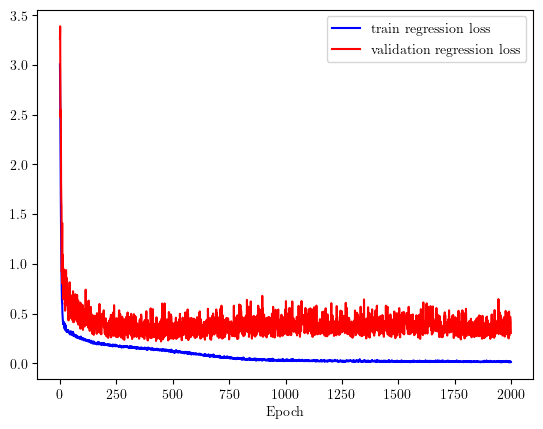

In [12]:
# Regression loss
train_regression_losses = regression_loss_values[0]
val_regression_losses = regression_loss_values[1]

plt.plot(train_regression_losses, "b", label="train regression loss")
plt.plot(val_regression_losses, "r", label="validation regression loss")

plt.legend()
plt.xlabel("Epoch")

## Testing

#### Testing the model

In [13]:
# Set the uncertainty function
uncertainty_function = uncertainty.functions.shannon_entropy

# Test the model
test_regression_loss,\
test_regression_losses = test(model,
                              device,
                              test_loader,
                              criterion_regression,
                              uncertainty_function)

print("Regression loss: ", test_regression_loss)

Regression loss:  0.22474707663059235


#### Comparing to the worst possible loss

In [14]:
dataset_dir = "/home/gabriel/PRE/datasets/dataset_multimodal_siamese_png_quantilebinning/traversal_costs.csv"
costs_df = pd.read_csv(dataset_dir)
costs = costs_df['traversal_cost'].to_numpy()
mean_dataset_value = costs_df['traversal_cost'].mean()

print(mean_dataset_value)

mean_loss = 0.

# Add a progress bar
train_loader_pbar = tqdm(train_loader, unit="batch")

# Loop over the training batches
for images,\
    traversal_costs,\
    linear_velocities in train_loader_pbar:
    mean_tensor_value = torch.tensor(np.full(list(traversal_costs.shape), mean_dataset_value), dtype=torch.float32)

    #loss = criterion_classification(mean_tensor_label, traversability_labels)
    #
    ## Accumulate batch loss to average over the epoch
    #train_loss += loss.item()
    #
    ## Get the number of correct predictions
    #train_correct += torch.sum(
    #    torch.argmax(mean_tensor_label, dim=1) == traversability_labels
    #    ).item()
    
    # Compute and accumulate the batch loss
    mean_loss += criterion_regression(
        mean_tensor_value,
        traversal_costs).item()

# Compute the losses and accuracies
mean_loss /= len(train_loader)
    
print(mean_loss)



3.140143006727703


  0%|          | 0/6 [00:00<?, ?batch/s]

100%|██████████| 6/6 [00:01<00:00,  4.19batch/s]

3.5356921752293906


#### Getting some stats about the dataset

## Save model parameters

In [15]:
# Save the model parameters
# torch.save(model.state_dict(), "multimodal_velocity.params")

## Assessing the relevance of the uncertainty

In [16]:
##import uncertainty.functions
##import uncertainty.evaluation
##
### Compute the test losses after successive removal of the samples
### with the highest loss and uncertainty
##test_losses_loss, test_losses_uncertainty =\
##    uncertainty.evaluation.uncertainty_relevance(
##        model,
##        device,
##        criterion_regression,
##        uncertainty_function,
##        test,
##        test_set,
##        test_regression_loss,
##        test_regression_losses)

#### Plotting the results

In [17]:
##plt.plot(range(0, 100, 10),
##         test_losses_loss,
##         "bo--",
##         label="removing samples with highest regression loss",
##         markersize=4)
##plt.plot(range(0, 100, 10),
##         test_losses_uncertainty,
##         "ro--",
##         label="removing samples with highest uncertainty",
##         markersize=4)
##
##plt.legend(loc="upper right")
##plt.xlabel("Percentage of samples removed")
##plt.ylabel("Regression error (MSE)")

## Generate a log directory

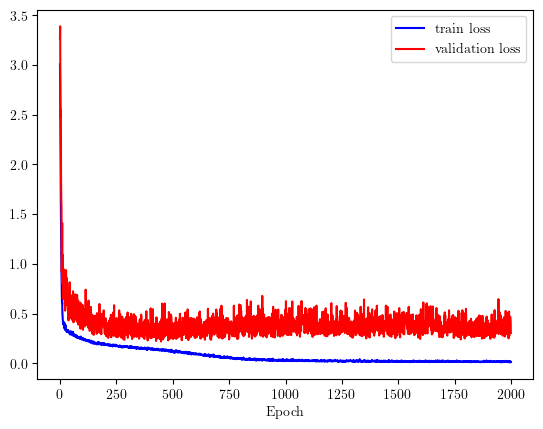

In [18]:
# Get the learning parameters table
params_table = parameters_table(dataset=params.learning.DATASET,
                                learning_params=LEARNING_PARAMS)

# Set the path to the results directory
if params.learning.LOG_DIR:
    results_directory = "logs/_" +\
                        params.learning.LOG_DIR
else:
    results_directory = "logs/_" +\
                        datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
                        
# Generate the log directory
generate_log(results_directory=results_directory,
             test_regression_loss=test_regression_loss,
             parameters_table=params_table,
             model=model,
             regression_loss_values=regression_loss_values)

### Ensemble learning

#### Training the models

In [ ]:
# Create a list of models
nb_models = 3
some_models = [ResNet18Velocity().to(device=device) for _ in range(nb_models)]

# Loop over the models
for i in range(nb_models):
    
    print(f"Training model {i+1}/{nb_models}")
    
    # Get all the parameters excepts the weights and bias of fc layer
    base_params = [param for name, param in some_models[i].named_parameters()
                   if name not in ["resnet18.fc.weight", "resnet18.fc.bias"]]

    # Define the optimizer, with a greater learning rate for the new fc layer
    optimizer = optim.SGD([
        {"params": base_params},
        {"params": some_models[i].resnet18.fc.parameters(),
         "lr": LEARNING_PARAMS["learning_rate"] * 10},
    ],
        lr=LEARNING_PARAMS["learning_rate"],
        momentum=LEARNING_PARAMS["momentum"],
        weight_decay=LEARNING_PARAMS["weight_decay"])
    
    # Loop over the epochs
    for epoch in range(LEARNING_PARAMS["nb_epochs"]):

        # Train the model
        train_loss, train_accuracy, train_regression_loss = train(some_models[i],
                                                                  device,
                                                                  train_loader,
                                                                  optimizer,
                                                                  criterion_classification,
                                                                  criterion_regression,
                                                                  bins_midpoints,
                                                                  epoch)

In [ ]:
# Create arrays to store the test losses
# test_losses_loss = np.zeros((nb_models, 10))
# test_losses_uncertainty = np.zeros((nb_models, 10))

uncertainty_function = uncertainty.functions.shannon_entropy

# Test the models
test_regression_loss, test_regression_losses, uncertainties = test_models(some_models,
                                                                          device,
                                                                          test_loader,
                                                                          criterion_classification,
                                                                          criterion_regression,
                                                                          bins_midpoints,
                                                                          uncertainty_function)
print("Test regression loss: ", test_regression_loss)

# Compute the test losses after successive removal of the samples with the highest loss and uncertainty
test_losses_loss, test_losses_uncertainty = \
    uncertainty.evaluation.uncertainty_relevance_models(some_models,
                                                        device,
                                                        criterion_classification,
                                                        criterion_regression,
                                                        bins_midpoints,
                                                        uncertainty_function,
                                                        test_models,
                                                        test_set,
                                                        test_regression_loss,
                                                        test_regression_losses,
                                                        uncertainties)

#### Plotting the results

In [ ]:
plt.plot(range(0, 100, 10),
         test_losses_loss,
         "bo--",
         label="removing samples with highest regression loss",
         markersize=4)
plt.plot(range(0, 100, 10),
         test_losses_uncertainty,
         "ro--",
         label="removing samples with highest uncertainty",
         markersize=4)

plt.legend(loc="upper right")
plt.xlabel("Percentage of samples removed")
plt.ylabel("Regression error (MSE)")